## Introduction<a id='introduction'></a>

**Purpose:**

Explore dataset to get a sense of which features are most predictive of EFS.

**Context:**

Hematopoietic stem cells, which reside in the bone marrow, are responsible for generating all blood cells, including red blood cells, platelet-producing cells, and immune system cells such as T cells, B cells, neutrophils, and natural killer cells. Allogeneic hematopoietic cell transplantation (HCT) can replace an individual's faulty hematopoietic stem cells with functional ones restoring healthy immune system function. 

Improving survival predictions for allogeneic HCT patients is a vital healthcare challenge. Current predictive models often fall short in addressing disparities related to socioeconomic status, race, and geography. Addressing these gaps is crucial for enhancing patient care, optimizing resource utilization, and rebuilding trust in the healthcare system.

The goal of the project is to predict an individual's risk score. (Target variable is ```efs```)

**Data:**

Project and data comes from [Kaggle](https://www.kaggle.com/competitions/equity-post-HCT-survival-predictions/overview)

**Outcomes of Data Wrangling:**
- Converted nans and nan-like values to 'NOT TESTED'
- graft_type and prod_type appear to be redundant, however 5% of values are mismatched. Keeping graft_type and removing prod_type
- Data confirms prognostic factors identified from UpToDate
    - Younger age trends with improved outcomes
        - Consider stratifying age by Infant, Pediatric, Adult (19-40), Adult (41-64), Senior (65+)
    - Increased comorbidities worsens outcome
        - Can stratify by aggregate comorbidity score of [0, 1-2, 3+] or [0,1,2,3,4+]
    - DRI score roughly predicts EFS
    - Cyto score does not predict EFS
    - karnofsky performance score does predict EFS with higher scores leading to improved outcomes. Note: KPS is designed for patients age 16+
    - cmv status does predict EFS with -/+ at most risk and +/- at the least risk
    - prior solid tumor does worsen outcome
    
**Outcomes from this notebook (EDA):**

1. Risk, patient, and HCT models result in similar accuracies in the range of 0.62-0.64 while donor-recipient models result in accuracies in the range of 0.56-0.58
2. PCA generally results in increased accuracies especially for reducing the number of dimensions in hla features, hct features, and patient features
3. Dropping features can result in increased accuracy suggesting that there is substantial noise in the dataset
4. Need to go through and drop all feature values that appear less 1% of the time

## Contents<a id='contents'></a>
* [Introduction](#introduction)
* [Contents](#contents)
* [Objectives](#objectives)
* [Predict EFS from Risk Scores](#predict_efs_from_risk_scores)
* [Predict EFS from Patient Parameters](#predict_efs_from_patient_parameters)
* [Predict EFS from Donor-Recipient Parameters](#predict_efs_from_donor-recipient_parameters)
* [Predict EFS from HCT Parameters and Donor Age](#predict_efs_from_hct_parameters_and_donor_age)
* [Summary](#summary)

## Objectives<a id='objectives'></a>

1. Predict EFS using only risk score data
2. Predict EFS using only patient parameters
3. Predict EFS using only donor-recipient parameters
4. Predict EFS using only HCT parameters and donor age

In [1]:
from collections import defaultdict
import numpy as np
from scipy.integrate import simpson
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams.update({'font.size': 12, 'figure.figsize':(4,3)})

C:\Users\kimvo\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from lifelines import KaplanMeierFitter, NelsonAalenFitter

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.decomposition import PCA
import shap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
class OneHotNan(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ohe = OneHotEncoder(sparse_output=False)
        X_oh = ohe.fit_transform(X)
        
        if True not in pd.isnull(ohe.categories_):
            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
        if True in pd.isnull(ohe.categories_):
            for ind, val in enumerate(ohe.categories_[0]):
                if pd.isnull(val):
                    nan_col = ind
            nan_rows = [ind for ind, val in enumerate(X_oh[:, nan_col]) if val > 0]

            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
            X_oh.loc[nan_rows,:] = pd.NA
            X_oh = X_oh.drop(columns=ohe.categories_[0][nan_col])
        return X_oh

class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        OH_NaN = OneHotNan()

        X_cat = pd.DataFrame()
        for cat_col in self.columns:
            df = OH_NaN.fit_transform(X[[cat_col]])

            new_cols = [cat_col+'_'+s for s in df.columns]
            X_cat = pd.concat([X_cat, df.rename(columns=dict(zip(df.columns, new_cols)))], axis=1)

        X_cat = X_cat.drop(columns=X_cat.columns[pd.Series(X_cat.columns.values).str.contains('NOT TESTED')])

        return X_cat

class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        scaler = StandardScaler()
        X_num = pd.DataFrame(scaler.fit_transform(X[self.columns]), columns=self.columns)
        return X_num

In [4]:
def remove_rare_vals(df, threshold=0.01):
    '''
    Remove categorical values which appear less than the threshold frequency
    '''
    cols = df.columns.values
    threshold = int(df.shape[0]*threshold)

    new_df = pd.DataFrame()

    for col in cols:
        remove_vals = []
        for key, val in df[col].value_counts().to_dict().items():
            if val < threshold:
                remove_vals.append(key)

        new_series = []
        for x in df[col]:
            if x in remove_vals:
                new_series.append('NOT TESTED')
            else:
                new_series.append(x)

        new_df[col] = new_series

    return new_df

def categorize_age(my_arr):
    '''
    Bin age according to thresholds identified from UpToDate
    '''
    age_cat = []
    for x in my_arr:
        if pd.isna(x):
            age_cat.append('NOT TESTED')
        elif x < 1: # 6
            age_cat.append('Infant')
        elif x < 18: # 25
            age_cat.append('Child')
        elif x < 40: # 45
            age_cat.append('Young Adult')
        elif x < 65: # 65
            age_cat.append('Adult')
        else:
            age_cat.append('Senior')
    return age_cat

def bin_comorbidity(my_arr):
    '''
    Bin Sorror comorbidity according to bins identified from HCT-CI
    '''
    return [str(x) if x < 4 else '4' for x in my_arr]

def red_dri_score(df):
    '''
    Reduces the cardinality of dri_score by mapping values to one another based on similarity to target
    '''
    new_arr = []
    for val in df['dri_score']:
        if val == 'High':
            new_arr.append('High')
        elif val in ['High - TED AML case <missing cytogenetics', 'Intermediate', 'Intermediate - TED AML case <missing cytogenetics', 'Low']:
            new_arr.append('Intermediate')
        else:
            new_arr.append('Low')
    return new_arr

def te_feature_mean(df, col):
    '''
    Target encode feature using mean of kaplan meier survival function
    '''
    mapper = df[[col, 'y_km']].groupby(col).mean().to_dict()['y_km']
    return df[col].replace(mapper)

In [5]:
def cross_validate(model, preprocessor, X, Y, n=5, shuffle=False, random_state=None, save_model=False, name=None):
    kf = StratifiedKFold(n_splits=n, shuffle=shuffle, random_state=random_state)
    callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    pred = pd.Series(index=Y.index, name=Y.name+'_pred')
    cv_history = defaultdict(int)

    for k, (train_index, test_index) in enumerate(kf.split(X, X['efs'])):
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]

        x_pipe, x_train = preprocessor(x_train)
        x_test = pd.DataFrame(x_pipe.transform(x_test), columns=x_train.columns)

        if save_model:
            callback_save = ModelCheckpoint(filepath = '../models/'+name+'_model_'+str(k)+'fold.keras', monitor='val_loss', save_best_only=True)
            history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=1000, validation_data=(x_test, y_test), verbose=0, callbacks=[callback_save, callback])
        else:
            history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=1000, validation_data=(x_test, y_test), verbose=0, callbacks=callback)

        pred.loc[test_index] = model.predict(x_test).reshape(-1)
        for key in history.history.keys():
            cv_history[key] += history.history[key][-1]/n

    return pred, cv_history

In [6]:
data = pd.read_csv('../data/interim/train.csv')

In [7]:
object_cols = list(data.columns[data.dtypes.values == 'O'])
num_cols = data.columns[(data.dtypes.values == 'int64') | (data.dtypes.values == 'float64')].drop(['Unnamed: 0', 'ID', 'year_hct'])

df = remove_rare_vals(data[object_cols])
df[num_cols] = data[num_cols]
df['age_at_hct_cat'] = categorize_age(data['age_at_hct'])
df['donor_age_cat'] = categorize_age(data['donor_age'])
df['binned_comorbidity'] = bin_comorbidity(data['comorbidity_score'])
df['donor-pt_age'] = df['donor_age'] - df['age_at_hct']

binary_cols = ['psych_disturb', 'diabetes', 'arrhythmia', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 
               'prior_tumor', 'rheum_issue', 'hepatic_mild', 'cardiac', 'pulm_moderate']
for col in binary_cols:
    df[col] = df[col].str.replace('No', 'NOT TESTED')

df['ethnicity'] = df['ethnicity'].str.replace('Not Hispanic or Latino','NOT TESTED')
df['ethnicity'] = df['ethnicity'].str.replace('Non-resident of the U.S.','NOT TESTED')
df = df.drop(columns='peptic_ulcer')

km = KaplanMeierFitter()
km.fit(df['efs_time'], df['efs'])
df['y_km'] = km.survival_function_at_times(df['efs_time']).values

na = NelsonAalenFitter()
na.fit(durations=df['efs_time'], event_observed=df['efs'])
df['y_na'] = -na.cumulative_hazard_at_times(df['efs_time']).values

df['dri_score_red'] = red_dri_score(df)
df['te_dri_score'] = te_feature_mean(df, 'dri_score')
df['te_prim_disease_hct'] = te_feature_mean(df, 'prim_disease_hct')
df['te_gvhd_proph'] = te_feature_mean(df, 'gvhd_proph')

df['pt_sex'] = df['sex_match'].replace({'M-M':'M', 'F-M':'M', 'M-F':'F', 'F-F':'F'})
df['dr_sex_match'] = df['sex_match'].replace({'M-M':1, 'F-M':-1, 'M-F':-1, 'F-F':1, 'NOT TESTED':0})

C:\Users\kimvo\AppData\Local\Temp\ipykernel_3488\755929577.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[col].replace(mapper)
C:\Users\kimvo\AppData\Local\Temp\ipykernel_3488\755929577.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df[col].replace(mapper)
C:\Users\kimvo\AppData\Local\Temp\ipykernel_3488\755929577.py:72: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. 

## Predict EFS Using only Risk Score Data<a id='predict_efs_using_only_risk_score_data'></a>

**Result:**

In [8]:
risk_cols = ['dri_score', 'cyto_score', 'cyto_score_detail', 'comorbidity_score', 'karnofsky_score']
risk_score_df = df[risk_cols]

### Datatypes and value counts

In [9]:
risk_score_df.dtypes

dri_score             object
cyto_score            object
cyto_score_detail     object
comorbidity_score    float64
karnofsky_score      float64
dtype: object

In [10]:
risk_score_df.isna().sum()

dri_score              0
cyto_score             0
cyto_score_detail      0
comorbidity_score    477
karnofsky_score      870
dtype: int64

In [11]:
risk_score_df['dri_score'].value_counts()

dri_score
Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
NOT TESTED cytogenetics                               2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
NOT TESTED                                             633
Intermediate - TED AML case <missing cytogenetics      481
Name: count, dtype: int64

In [12]:
risk_score_df['cyto_score'].value_counts()

cyto_score
NOT TESTED      9464
Poor            8802
Intermediate    6376
Favorable       3011
Normal           643
Other            504
Name: count, dtype: int64

In [13]:
risk_score_df['cyto_score_detail'].value_counts()

cyto_score_detail
NOT TESTED      13111
Intermediate    11158
Poor             3323
Favorable        1208
Name: count, dtype: int64

In [14]:
risk_score_df[['cyto_score', 'cyto_score_detail']].value_counts()

cyto_score    cyto_score_detail
NOT TESTED    NOT TESTED           8203
Intermediate  Intermediate         5339
Poor          NOT TESTED           3465
              Poor                 2477
Favorable     Intermediate         2272
Poor          Intermediate         2217
NOT TESTED    Intermediate          862
Poor          Favorable             643
Intermediate  NOT TESTED            557
Normal        NOT TESTED            337
Favorable     NOT TESTED            332
              Poor                  315
Normal        Intermediate          245
Intermediate  Poor                  242
              Favorable             238
NOT TESTED    Poor                  230
Other         Intermediate          223
              NOT TESTED            217
NOT TESTED    Favorable             169
Favorable     Favorable              92
Normal        Favorable              35
Other         Poor                   33
              Favorable              31
Normal        Poor                   26
Name: co

### Model 1

Full space

In [86]:
def preprocess_risk(df):
    feature_union = FeatureUnion([
        ('cat_trans', CategoricalTransformer(columns=['dri_score', 'cyto_score', 'cyto_score_detail', 'binned_comorbidity'])),
        ('num_trans', NumericalTransformer(columns=['karnofsky_score']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('knn_impute', KNNImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    transformers = ['cat_trans', 'num_trans']
    cols = []
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    
    return knn_impute_pipe, df_imputed

In [87]:
riskx_train, riskx_test, risky_train, risky_test = train_test_split(df, df['efs'], test_size=0.2)
risk_pipe, riskx_train = preprocess_risk(riskx_train)
riskx_test = pd.DataFrame(risk_pipe.transform(riskx_test), columns=riskx_train.columns)

In [10]:
riskx_train.columns

Index(['dri_score_High', 'dri_score_High - TED AML case <missing cytogenetics',
       'dri_score_Intermediate',
       'dri_score_Intermediate - TED AML case <missing cytogenetics',
       'dri_score_Low', 'dri_score_N/A - non-malignant indication',
       'dri_score_N/A - pediatric', 'cyto_score_Favorable',
       'cyto_score_Intermediate', 'cyto_score_Normal', 'cyto_score_Other',
       'cyto_score_Poor', 'cyto_score_detail_Favorable',
       'cyto_score_detail_Intermediate', 'cyto_score_detail_Poor',
       'binned_comorbidity_0.0', 'binned_comorbidity_1.0',
       'binned_comorbidity_2.0', 'binned_comorbidity_3.0',
       'binned_comorbidity_4', 'karnofsky_score'],
      dtype='object')

In [88]:
input_risk = keras.Input(shape=(riskx_train.shape[1],))
x = layers.Dense(riskx_train.shape[1],activation='relu')(input_risk)
x = layers.BatchNormalization()(x)
x = layers.Dense(riskx_train.shape[1],activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(5,activation='relu')(x)
output_risk = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_risk, outputs=output_risk, name='risk_model')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "risk_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense_24 (Dense)            (None, 21)                462       
                                                                 
 batch_normalization_12 (Ba  (None, 21)                84        
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 21)                462       
                                                                 
 batch_normalization_13 (Ba  (None, 21)                84        
 tchNormalization)                                               
                                                                 
 dense_26 (Dense)            (None, 5)                 1

In [89]:
pred, scores = cross_validate(model, preprocess_risk, df, df['efs'], n=5, shuffle=True, random_state=0)

Epoch 31: early stopping
180/180 [==============================] - 1s 2ms/step


C:\Users\kimvo\AppData\Local\Temp\ipykernel_12560\2211170994.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pred = pd.concat([pred, pd.Series(model.predict(x_test).reshape(-1), index=y_test.index)], axis=0)


Epoch 11: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step


In [90]:
scores

defaultdict(int,
            {'loss': 0.22212414145469667,
             'accuracy': 0.6400086760520936,
             'mse': 0.22212414145469667,
             'mae': 0.4440638244152069,
             'val_loss': 0.22577598094940182,
             'val_accuracy': 0.6279861211776733,
             'val_mse': 0.22577598094940182,
             'val_mae': 0.44884008765220645})

In [ ]:
callback_a = ModelCheckpoint(filepath = '../models/risk_model.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history = model.fit(x=riskx_train, y=risky_train, batch_size=128, epochs=25, validation_data=(riskx_test, risky_test), callbacks=[callback_a, callback_b])

In [91]:
callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history = model.fit(x=riskx_train, y=risky_train, batch_size=128, epochs=25, validation_data=(riskx_test, risky_test), callbacks=callback)

Epoch 1/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2223 - accuracy: 0.6405 - mse: 0.2223 - mae: 0.4439 - val_loss: 0.2223 - val_accuracy: 0.6378 - val_mse: 0.2223 - val_mae: 0.4423
Epoch 2/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2223 - accuracy: 0.6412 - mse: 0.2223 - mae: 0.4438 - val_loss: 0.2231 - val_accuracy: 0.6354 - val_mse: 0.2231 - val_mae: 0.4446
Epoch 3/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2219 - accuracy: 0.6398 - mse: 0.2219 - mae: 0.4434 - val_loss: 0.2236 - val_accuracy: 0.6345 - val_mse: 0.2236 - val_mae: 0.4459
Epoch 4/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2218 - accuracy: 0.6414 - mse: 0.2218 - mae: 0.4435 - val_loss: 0.2234 - val_accuracy: 0.6345 - val_mse: 0.2234 - val_mae: 0.4427
Epoch 5/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2218 - accuracy: 0.6421 - mse: 0.2218 - mae: 0.4433 - val_loss: 0.2243 - val_accuracy: 0.6344 - val_

180/180 [==============================] - 0s 2ms/step
AUC:  0.6128932966748317


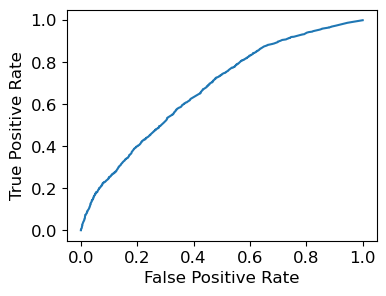

In [92]:
fpr, tpr, thresholds = roc_curve(risky_test, model.predict(riskx_test))

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='efs_pred', ylabel='Count'>

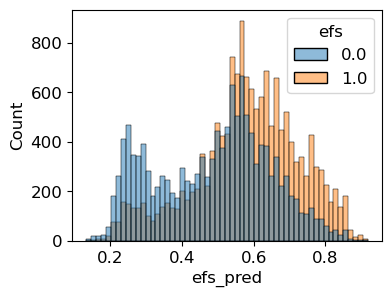

In [93]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

In [94]:
x_train_sample = riskx_train.sample(1000).values
risk_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = risk_shap.shap_values(riskx_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=riskx_train.columns.values, data=riskx_test.values, base_values=model.predict(x_train_sample).mean())

C:\Users\kimvo\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


32/32 [==============================] - 0s 3ms/step


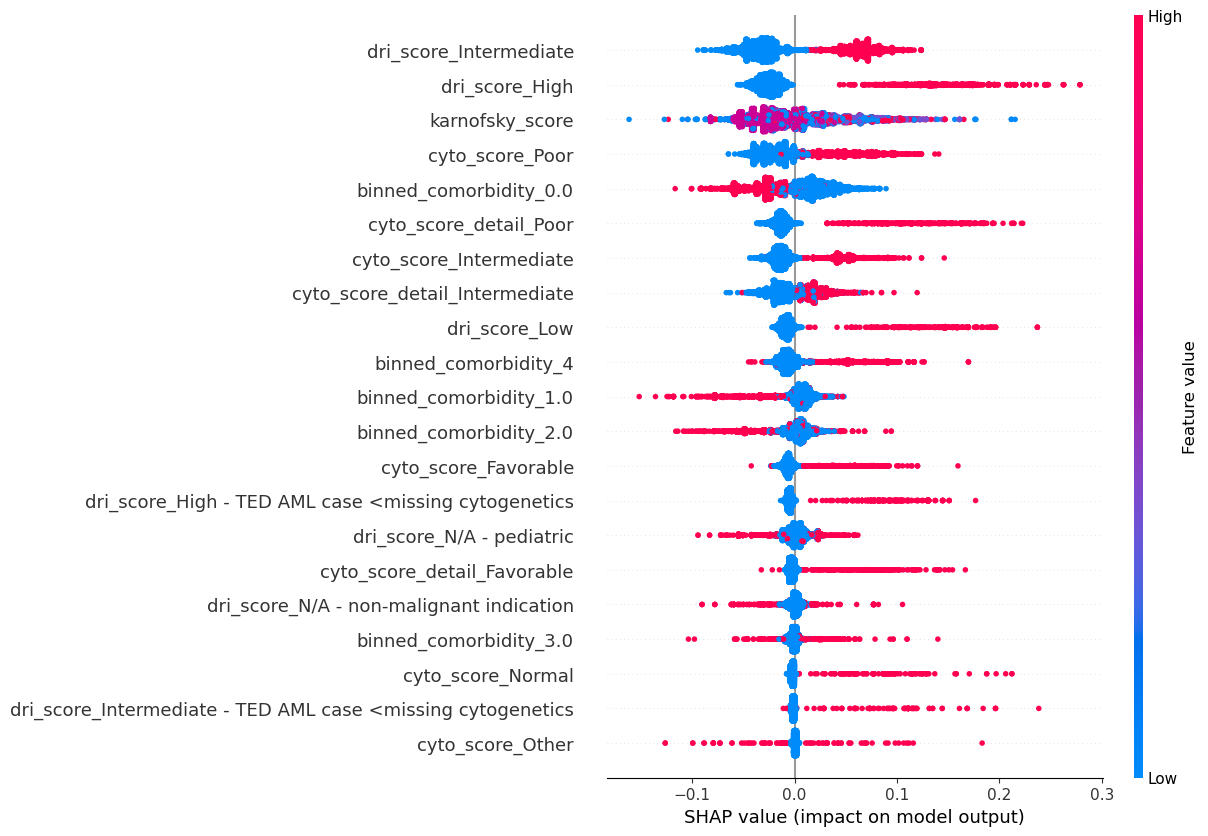

In [95]:
shap.plots.beeswarm(shap_vals, max_display=21)

### Model 2
Making comorbidity a numerical feature

In [96]:
def preprocess_risk(df):
    feature_union = FeatureUnion([
        ('cat_trans', CategoricalTransformer(columns=['dri_score', 'cyto_score', 'cyto_score_detail'])),
        ('num_trans', NumericalTransformer(columns=['binned_comorbidity', 'karnofsky_score']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('knn_impute', KNNImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    transformers = ['cat_trans', 'num_trans']
    cols = []
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    
    return knn_impute_pipe, df_imputed

In [97]:
riskx_train, riskx_test, risky_train, risky_test = train_test_split(df, df['efs'], test_size=0.2)
risk_pipe, riskx_train = preprocess_risk(riskx_train)
riskx_test = pd.DataFrame(risk_pipe.transform(riskx_test), columns=riskx_train.columns)

In [98]:
input_risk = keras.Input(shape=(riskx_train.shape[1],))
x = layers.Dense(riskx_train.shape[1],activation='relu')(input_risk)
x = layers.BatchNormalization()(x)
x = layers.Dense(riskx_train.shape[1],activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(5,activation='relu')(x)
output_risk = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_risk, outputs=output_risk, name='risk_model')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "risk_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense_28 (Dense)            (None, 17)                306       
                                                                 
 batch_normalization_14 (Ba  (None, 17)                68        
 tchNormalization)                                               
                                                                 
 dense_29 (Dense)            (None, 17)                306       
                                                                 
 batch_normalization_15 (Ba  (None, 17)                68        
 tchNormalization)                                               
                                                                 
 dense_30 (Dense)            (None, 5)                 9

In [99]:
pred, scores = cross_validate(model, preprocess_risk, df, df['efs'], n=5, shuffle=True, random_state=0)

Epoch 28: early stopping
180/180 [==============================] - 0s 2ms/step


C:\Users\kimvo\AppData\Local\Temp\ipykernel_12560\2211170994.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pred = pd.concat([pred, pd.Series(model.predict(x_test).reshape(-1), index=y_test.index)], axis=0)


Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 1s 4ms/step


In [100]:
scores

defaultdict(int,
            {'loss': 0.2232650250196457,
             'accuracy': 0.6377951383590699,
             'mse': 0.2232650250196457,
             'mae': 0.4466120660305023,
             'val_loss': 0.22604030668735503,
             'val_accuracy': 0.632361114025116,
             'val_mse': 0.22604030668735503,
             'val_mae': 0.449183839559555})

In [ ]:
callback_a = ModelCheckpoint(filepath = '../models/risk_model.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [101]:
callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history = model.fit(x=riskx_train, y=risky_train, batch_size=128, epochs=25, validation_data=(riskx_test, risky_test), callbacks=callback)

Epoch 1/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2239 - accuracy: 0.6375 - mse: 0.2239 - mae: 0.4476 - val_loss: 0.2215 - val_accuracy: 0.6396 - val_mse: 0.2215 - val_mae: 0.4453
Epoch 2/25
180/180 [==============================] - 1s 5ms/step - loss: 0.2236 - accuracy: 0.6378 - mse: 0.2236 - mae: 0.4473 - val_loss: 0.2222 - val_accuracy: 0.6398 - val_mse: 0.2222 - val_mae: 0.4455
Epoch 3/25
180/180 [==============================] - 1s 5ms/step - loss: 0.2234 - accuracy: 0.6388 - mse: 0.2234 - mae: 0.4465 - val_loss: 0.2223 - val_accuracy: 0.6392 - val_mse: 0.2223 - val_mae: 0.4443
Epoch 4/25
180/180 [==============================] - 1s 5ms/step - loss: 0.2235 - accuracy: 0.6389 - mse: 0.2235 - mae: 0.4464 - val_loss: 0.2226 - val_accuracy: 0.6380 - val_mse: 0.2226 - val_mae: 0.4470
Epoch 5/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2233 - accuracy: 0.6390 - mse: 0.2233 - mae: 0.4468 - val_loss: 0.2227 - val_accuracy: 0.6378 - val_

180/180 [==============================] - 0s 2ms/step
AUC:  0.6291176135745078


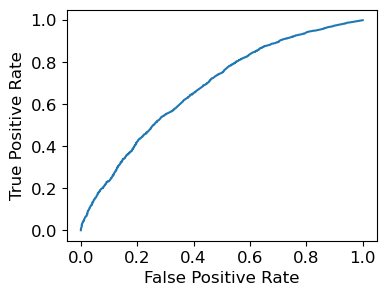

In [102]:
fpr, tpr, thresholds = roc_curve(risky_test, model.predict(riskx_test))

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='efs_pred', ylabel='Count'>

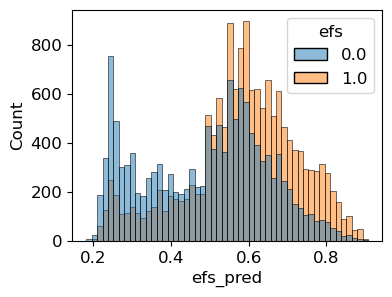

In [103]:
df_pred = pd.concat([df['efs'], pd.Series(pred, name='efs_pred')], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

In [104]:
x_train_sample = riskx_train.sample(1000).values
risk_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = risk_shap.shap_values(riskx_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=riskx_train.columns.values, data=riskx_test.values, base_values=model.predict(x_train_sample).mean())

C:\Users\kimvo\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


32/32 [==============================] - 0s 3ms/step


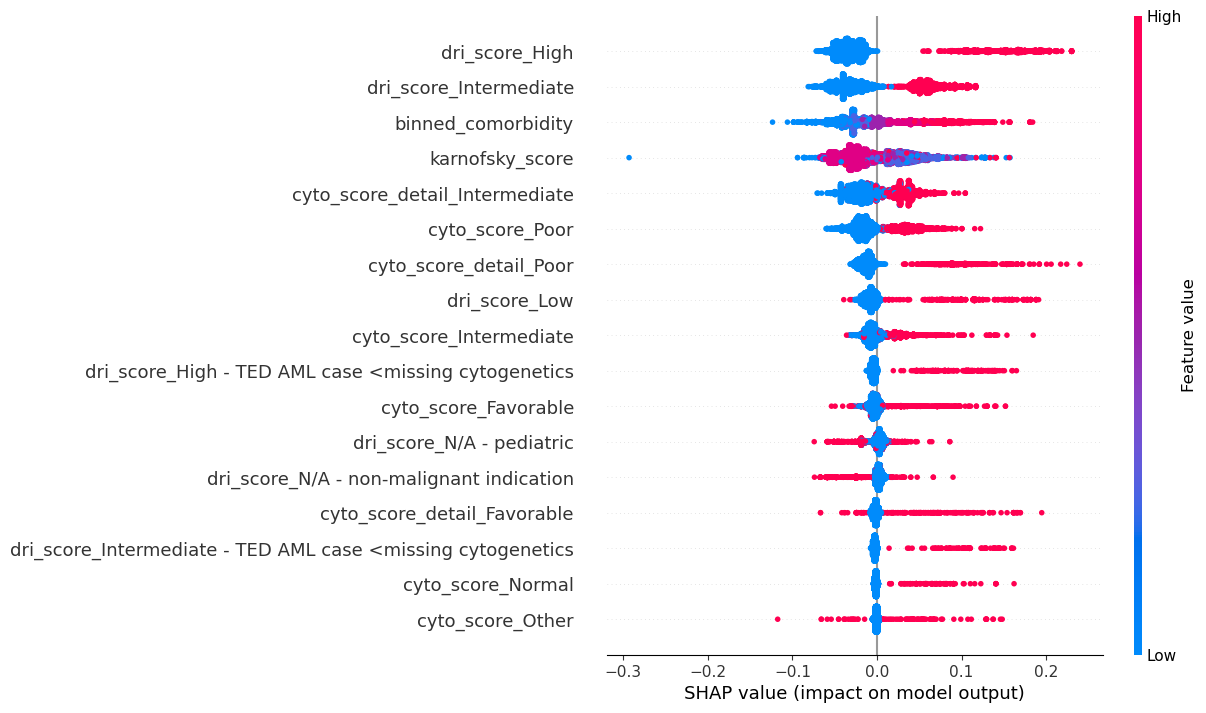

In [105]:
shap.plots.beeswarm(shap_vals, max_display=21)

### Model 3

Using dri_score_red instead of dri_score. Also keeping change from model 2

In [106]:
def preprocess_risk(df):
    feature_union = FeatureUnion([
        ('cat_trans', CategoricalTransformer(columns=['dri_score_red', 'cyto_score', 'cyto_score_detail'])),
        ('num_trans', NumericalTransformer(columns=['binned_comorbidity', 'karnofsky_score']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('knn_impute', KNNImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    transformers = ['cat_trans', 'num_trans']
    cols = []
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    
    return knn_impute_pipe, df_imputed

In [107]:
riskx_train, riskx_test, risky_train, risky_test = train_test_split(df, df['efs'], test_size=0.2)
risk_pipe, riskx_train = preprocess_risk(riskx_train)
riskx_test = pd.DataFrame(risk_pipe.transform(riskx_test), columns=riskx_train.columns)

In [108]:
input_risk = keras.Input(shape=(riskx_train.shape[1],))
x = layers.Dense(riskx_train.shape[1],activation='relu')(input_risk)
x = layers.BatchNormalization()(x)
x = layers.Dense(riskx_train.shape[1],activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(5,activation='relu')(x)
output_risk = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_risk, outputs=output_risk, name='risk_model')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "risk_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_32 (Dense)            (None, 13)                182       
                                                                 
 batch_normalization_16 (Ba  (None, 13)                52        
 tchNormalization)                                               
                                                                 
 dense_33 (Dense)            (None, 13)                182       
                                                                 
 batch_normalization_17 (Ba  (None, 13)                52        
 tchNormalization)                                               
                                                                 
 dense_34 (Dense)            (None, 5)                 7

In [109]:
pred, scores = cross_validate(model, preprocess_risk, df, df['efs'], n=5, shuffle=True, random_state=0)

Epoch 55: early stopping
180/180 [==============================] - 0s 2ms/step


C:\Users\kimvo\AppData\Local\Temp\ipykernel_12560\2211170994.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pred = pd.concat([pred, pd.Series(model.predict(x_test).reshape(-1), index=y_test.index)], axis=0)


Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step


In [110]:
scores

defaultdict(int,
            {'loss': 0.224163019657135,
             'accuracy': 0.6357899188995362,
             'mse': 0.224163019657135,
             'mae': 0.4481998205184936,
             'val_loss': 0.22559106945991514,
             'val_accuracy': 0.6351736068725585,
             'val_mse': 0.22559106945991514,
             'val_mae': 0.4499294757843018})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='efs_pred', ylabel='Count'>

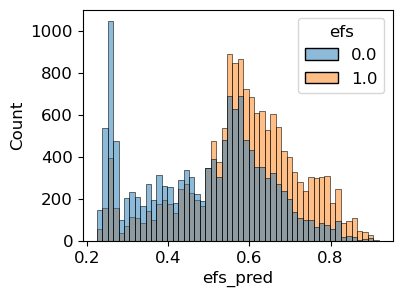

In [111]:
df_pred = pd.concat([df['efs'], pd.Series(pred, name='efs_pred')], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

In [40]:
callback_a = ModelCheckpoint(filepath = '../models/risk_model.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [112]:
callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history = model.fit(x=riskx_train, y=risky_train, batch_size=128, epochs=25, validation_data=(riskx_test, risky_test), callbacks=callback)

Epoch 1/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2245 - accuracy: 0.6359 - mse: 0.2245 - mae: 0.4484 - val_loss: 0.2234 - val_accuracy: 0.6392 - val_mse: 0.2234 - val_mae: 0.4451
Epoch 2/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2242 - accuracy: 0.6354 - mse: 0.2242 - mae: 0.4476 - val_loss: 0.2239 - val_accuracy: 0.6398 - val_mse: 0.2239 - val_mae: 0.4504
Epoch 3/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2242 - accuracy: 0.6348 - mse: 0.2242 - mae: 0.4488 - val_loss: 0.2239 - val_accuracy: 0.6368 - val_mse: 0.2239 - val_mae: 0.4483
Epoch 4/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2243 - accuracy: 0.6358 - mse: 0.2243 - mae: 0.4479 - val_loss: 0.2243 - val_accuracy: 0.6368 - val_mse: 0.2243 - val_mae: 0.4500
Epoch 5/25
180/180 [==============================] - 1s 4ms/step - loss: 0.2241 - accuracy: 0.6357 - mse: 0.2241 - mae: 0.4482 - val_loss: 0.2242 - val_accuracy: 0.6384 - val_

180/180 [==============================] - 0s 2ms/step
AUC:  0.6393383240108009


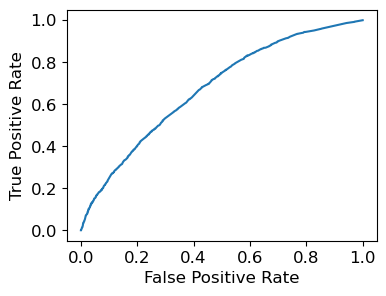

In [113]:
fpr, tpr, thresholds = roc_curve(risky_test, model.predict(riskx_test))

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

In [114]:
x_train_sample = riskx_train.sample(1000).values
risk_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = risk_shap.shap_values(riskx_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=riskx_train.columns.values, data=riskx_test.values, base_values=model.predict(x_train_sample).mean())

C:\Users\kimvo\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


32/32 [==============================] - 0s 2ms/step


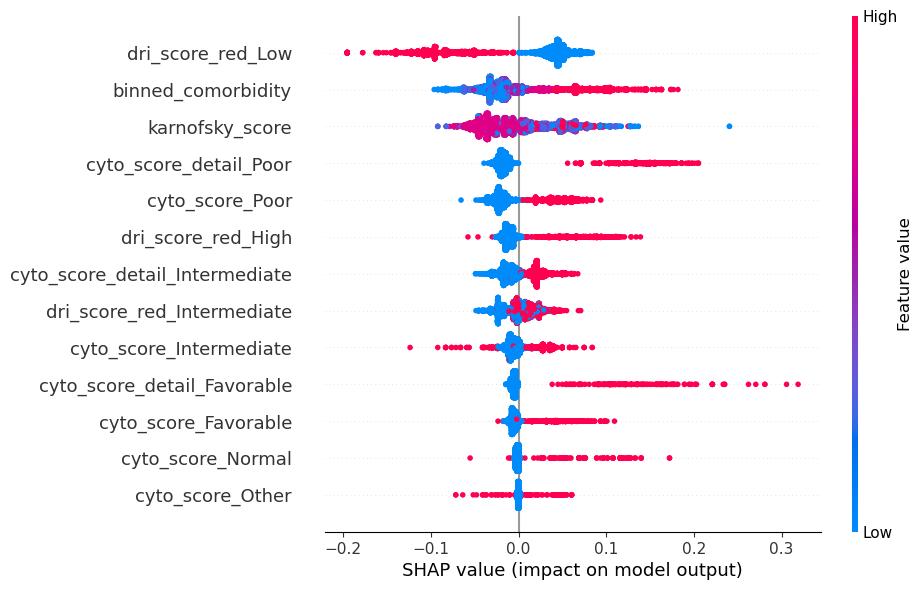

In [115]:
shap.plots.beeswarm(shap_vals, max_display=21)

### Model 4

binning karnofsky score into < 50, 50-70, and > 70

In [116]:
df['karnofsky_score'].value_counts()

karnofsky_score
90.0     15336
70.0      6690
100.0     2476
80.0      2036
60.0      1291
50.0        91
40.0        10
Name: count, dtype: int64

In [117]:
new_arr = []
for x in df['karnofsky_score']:
    if x < 50:
        new_arr.append('NOT TESTED')
    elif x <= 70:
        new_arr.append('Intermediate')
    elif x > 70:
        new_arr.append('High')
    else:
        new_arr.append('NOT TESTED')
df['karnofsky_score_cat'] = new_arr

In [118]:
df['karnofsky_score_cat'].value_counts()

karnofsky_score_cat
High            19848
Intermediate     8072
NOT TESTED        880
Name: count, dtype: int64

In [119]:
def preprocess_risk(df):
    feature_union = FeatureUnion([
        ('cat_trans', CategoricalTransformer(columns=['dri_score_red', 'cyto_score', 'cyto_score_detail', 'karnofsky_score_cat'])),
        ('num_trans', NumericalTransformer(columns=['binned_comorbidity']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('knn_impute', KNNImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    transformers = ['cat_trans', 'num_trans']
    cols = []
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    
    return knn_impute_pipe, df_imputed

In [120]:
riskx_train, riskx_test, risky_train, risky_test = train_test_split(df, df['efs'], test_size=0.2)
risk_pipe, riskx_train = preprocess_risk(riskx_train)
riskx_test = pd.DataFrame(risk_pipe.transform(riskx_test), columns=riskx_train.columns)

In [121]:
input_risk = keras.Input(shape=(riskx_train.shape[1],))
x = layers.Dense(riskx_train.shape[1],activation='relu')(input_risk)
x = layers.BatchNormalization()(x)
x = layers.Dense(riskx_train.shape[1],activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(5,activation='relu')(x)
output_risk = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_risk, outputs=output_risk, name='risk_model')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "risk_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 14)]              0         
                                                                 
 dense_36 (Dense)            (None, 14)                210       
                                                                 
 batch_normalization_18 (Ba  (None, 14)                56        
 tchNormalization)                                               
                                                                 
 dense_37 (Dense)            (None, 14)                210       
                                                                 
 batch_normalization_19 (Ba  (None, 14)                56        
 tchNormalization)                                               
                                                                 
 dense_38 (Dense)            (None, 5)                 7

In [122]:
pred, scores = cross_validate(model, preprocess_risk, df, df['efs'], n=5, shuffle=True, random_state=0)

Epoch 35: early stopping
180/180 [==============================] - 0s 2ms/step


C:\Users\kimvo\AppData\Local\Temp\ipykernel_12560\2211170994.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pred = pd.concat([pred, pd.Series(model.predict(x_test).reshape(-1), index=y_test.index)], axis=0)


Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step


In [123]:
scores

defaultdict(int,
            {'loss': 0.2254379391670227,
             'accuracy': 0.6340538144111634,
             'mse': 0.2254379391670227,
             'mae': 0.45045404434204095,
             'val_loss': 0.22682571709156035,
             'val_accuracy': 0.6278819561004638,
             'val_mse': 0.22682571709156035,
             'val_mae': 0.45269863009452815})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='efs_pred', ylabel='Count'>

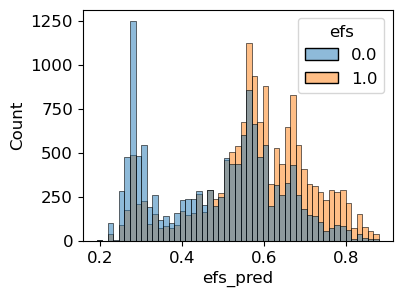

In [124]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

In [ ]:
callback_a = ModelCheckpoint(filepath = '../models/risk_model.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history = model.fit(x=riskx_train, y=risky_train, batch_size=128, epochs=25, validation_data=(riskx_test, risky_test), callbacks=[callback_a, callback_b])

In [125]:
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history = model.fit(x=riskx_train, y=risky_train, batch_size=128, epochs=100, validation_data=(riskx_test, risky_test), callbacks=callback_b)

Epoch 1/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2254 - accuracy: 0.6333 - mse: 0.2254 - mae: 0.4512 - val_loss: 0.2245 - val_accuracy: 0.6389 - val_mse: 0.2245 - val_mae: 0.4484
Epoch 2/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2254 - accuracy: 0.6331 - mse: 0.2254 - mae: 0.4500 - val_loss: 0.2249 - val_accuracy: 0.6403 - val_mse: 0.2249 - val_mae: 0.4501
Epoch 3/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2250 - accuracy: 0.6345 - mse: 0.2250 - mae: 0.4499 - val_loss: 0.2254 - val_accuracy: 0.6363 - val_mse: 0.2254 - val_mae: 0.4510
Epoch 4/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2253 - accuracy: 0.6326 - mse: 0.2253 - mae: 0.4500 - val_loss: 0.2252 - val_accuracy: 0.6359 - val_mse: 0.2252 - val_mae: 0.4501
Epoch 5/100
180/180 [==============================] - 1s 5ms/step - loss: 0.2254 - accuracy: 0.6327 - mse: 0.2254 - mae: 0.4506 - val_loss: 0.2255 - val_accuracy: 0.6385 -

180/180 [==============================] - 0s 2ms/step
AUC:  0.6250046168185405


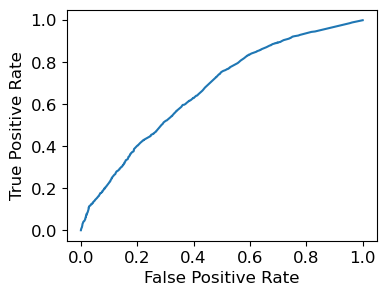

In [126]:
fpr, tpr, thresholds = roc_curve(risky_test, model.predict(riskx_test))

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

In [127]:
x_train_sample = riskx_train.sample(1000).values
risk_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = risk_shap.shap_values(riskx_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=riskx_train.columns.values, data=riskx_test.values, base_values=model.predict(x_train_sample).mean())

C:\Users\kimvo\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


32/32 [==============================] - 0s 5ms/step


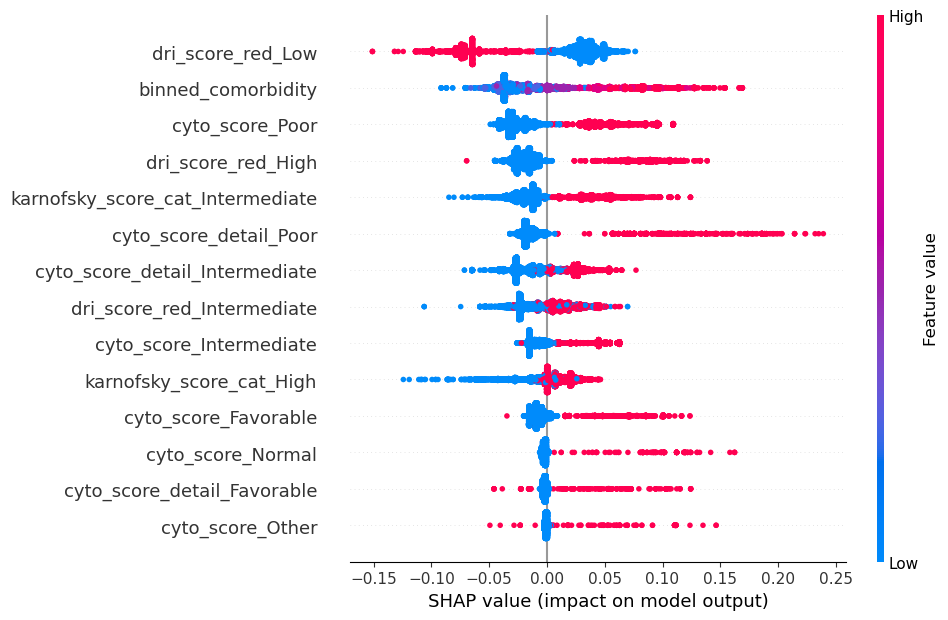

In [128]:
shap.plots.beeswarm(shap_vals, max_display=21)

### Model 5

Playing around with cyto_score

In [143]:
df['cyto_score'].value_counts()

cyto_score
NOT TESTED      9464
Poor            8802
Intermediate    6376
Favorable       3011
Normal           643
Other            504
Name: count, dtype: int64

In [144]:
df['cyto_score_red'] = df['cyto_score'].replace('Other', 'NOT TESTED')

In [146]:
def preprocess_risk(df):
    feature_union = FeatureUnion([
        ('cat_trans', CategoricalTransformer(columns=['dri_score_red', 'cyto_score_red', 'cyto_score_detail'])),
        ('num_trans', NumericalTransformer(columns=['binned_comorbidity', 'karnofsky_score']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('knn_impute', KNNImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    transformers = ['cat_trans', 'num_trans']
    cols = []
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    
    return knn_impute_pipe, df_imputed

In [147]:
riskx_train, riskx_test, risky_train, risky_test = train_test_split(df, df['efs'], test_size=0.2)
risk_pipe, riskx_train = preprocess_risk(riskx_train)
riskx_test = pd.DataFrame(risk_pipe.transform(riskx_test), columns=riskx_train.columns)

In [148]:
input_risk = keras.Input(shape=(riskx_train.shape[1],))
x = layers.Dense(riskx_train.shape[1],activation='relu')(input_risk)
x = layers.BatchNormalization()(x)
x = layers.Dense(riskx_train.shape[1],activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(5,activation='relu')(x)
output_risk = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_risk, outputs=output_risk, name='risk_model')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "risk_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 12)]              0         
                                                                 
 dense_44 (Dense)            (None, 12)                156       
                                                                 
 batch_normalization_22 (Ba  (None, 12)                48        
 tchNormalization)                                               
                                                                 
 dense_45 (Dense)            (None, 12)                156       
                                                                 
 batch_normalization_23 (Ba  (None, 12)                48        
 tchNormalization)                                               
                                                                 
 dense_46 (Dense)            (None, 5)                 6

In [149]:
pred, scores = cross_validate(model, preprocess_risk, df, df['efs'], n=5, shuffle=True, random_state=0)

Epoch 29: early stopping
180/180 [==============================] - 1s 2ms/step


C:\Users\kimvo\AppData\Local\Temp\ipykernel_12560\2211170994.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pred = pd.concat([pred, pd.Series(model.predict(x_test).reshape(-1), index=y_test.index)], axis=0)


Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 12: early stopping
180/180 [==============================] - 0s 2ms/step


In [150]:
scores

defaultdict(int,
            {'loss': 0.22474712133407593,
             'accuracy': 0.6341406345367432,
             'mse': 0.22474712133407593,
             'mae': 0.44945679903030394,
             'val_loss': 0.2258872389793396,
             'val_accuracy': 0.6322916626930237,
             'val_mse': 0.2258872389793396,
             'val_mae': 0.45023908019065856})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='efs_pred', ylabel='Count'>

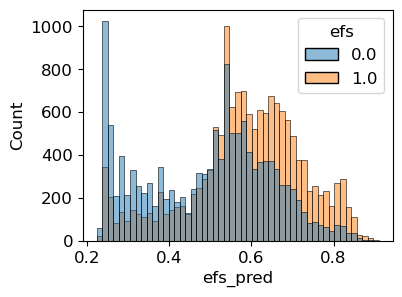

In [151]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

In [ ]:
callback_a = ModelCheckpoint(filepath = '../models/risk_model.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history = model.fit(x=riskx_train, y=risky_train, batch_size=128, epochs=25, validation_data=(riskx_test, risky_test), callbacks=[callback_a, callback_b])

In [152]:
callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history = model.fit(x=riskx_train, y=risky_train, batch_size=128, epochs=100, validation_data=(riskx_test, risky_test), callbacks=callback_)

Epoch 1/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2244 - accuracy: 0.6343 - mse: 0.2244 - mae: 0.4486 - val_loss: 0.2254 - val_accuracy: 0.6365 - val_mse: 0.2254 - val_mae: 0.4499
Epoch 2/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2244 - accuracy: 0.6326 - mse: 0.2244 - mae: 0.4490 - val_loss: 0.2264 - val_accuracy: 0.6295 - val_mse: 0.2264 - val_mae: 0.4508
Epoch 3/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2241 - accuracy: 0.6336 - mse: 0.2241 - mae: 0.4479 - val_loss: 0.2262 - val_accuracy: 0.6347 - val_mse: 0.2262 - val_mae: 0.4516
Epoch 4/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2245 - accuracy: 0.6316 - mse: 0.2245 - mae: 0.4489 - val_loss: 0.2264 - val_accuracy: 0.6328 - val_mse: 0.2264 - val_mae: 0.4514
Epoch 5/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2242 - accuracy: 0.6342 - mse: 0.2242 - mae: 0.4483 - val_loss: 0.2264 - val_accuracy: 0.6330 -

180/180 [==============================] - 0s 2ms/step
AUC:  0.6292712561160355


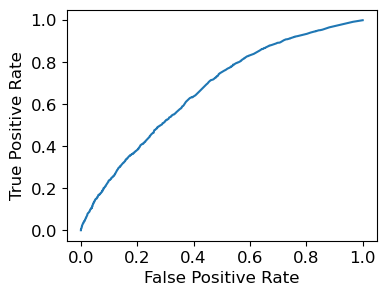

In [153]:
fpr, tpr, thresholds = roc_curve(risky_test, model.predict(riskx_test))

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

In [154]:
x_train_sample = riskx_train.sample(1000).values
risk_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = risk_shap.shap_values(riskx_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=riskx_train.columns.values, data=riskx_test.values, base_values=model.predict(x_train_sample).mean())

C:\Users\kimvo\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


32/32 [==============================] - 0s 2ms/step


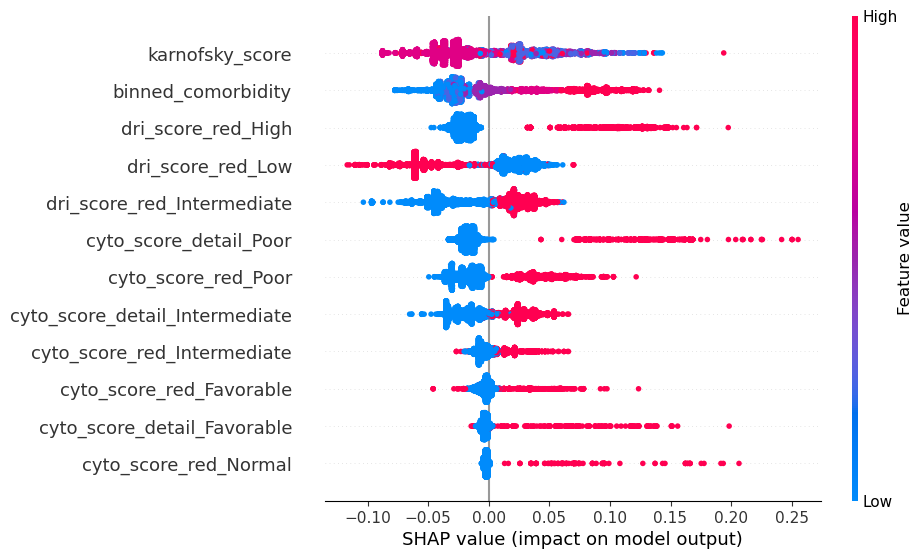

In [155]:
shap.plots.beeswarm(shap_vals, max_display=21)

### Model 6

Applying PCA to cyto_score and cyto_score_detail

In [144]:
df['cyto_score_red'] = df['cyto_score'].replace('Other', 'NOT TESTED')

In [167]:
def preprocess_risk(df):
    feature_union = FeatureUnion([
        ('cat_features', Pipeline([
            ('cat_trans', CategoricalTransformer(columns=['cyto_score_red', 'cyto_score_detail'])),
            ('pca', PCA(n_components=0.95, svd_solver='full'))
        ])),
        ('cat_trans', CategoricalTransformer(columns=['dri_score_red'])),
        ('num_trans', NumericalTransformer(columns=['binned_comorbidity', 'karnofsky_score']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('knn_impute', KNNImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    cols = ['pca_'+str(i) for i in range(1, knn_impute_pipe['features']['cat_features'].transform(df).shape[1]+1)]
    transformers = ['cat_trans', 'num_trans']
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    
    return knn_impute_pipe, df_imputed

In [168]:
riskx_train, riskx_test, risky_train, risky_test = train_test_split(df, df['efs'], test_size=0.2)
risk_pipe, riskx_train = preprocess_risk(riskx_train)
riskx_test = pd.DataFrame(risk_pipe.transform(riskx_test), columns=riskx_train.columns)

In [169]:
input_risk = keras.Input(shape=(riskx_train.shape[1],))
x = layers.Dense(riskx_train.shape[1],activation='relu')(input_risk)
x = layers.BatchNormalization()(x)
x = layers.Dense(riskx_train.shape[1],activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(5,activation='relu')(x)
output_risk = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_risk, outputs=output_risk, name='risk_model')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "risk_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 11)]              0         
                                                                 
 dense_52 (Dense)            (None, 11)                132       
                                                                 
 batch_normalization_26 (Ba  (None, 11)                44        
 tchNormalization)                                               
                                                                 
 dense_53 (Dense)            (None, 11)                132       
                                                                 
 batch_normalization_27 (Ba  (None, 11)                44        
 tchNormalization)                                               
                                                                 
 dense_54 (Dense)            (None, 5)                 6

In [170]:
pred, scores = cross_validate(model, preprocess_risk, df, df['efs'], n=5, shuffle=True, random_state=0)

Epoch 41: early stopping
180/180 [==============================] - 0s 2ms/step


C:\Users\kimvo\AppData\Local\Temp\ipykernel_12560\2211170994.py:16: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  pred = pd.concat([pred, pd.Series(model.predict(x_test).reshape(-1), index=y_test.index)], axis=0)


Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step


In [171]:
scores

defaultdict(int,
            {'loss': 0.2247794598340988,
             'accuracy': 0.634704852104187,
             'mse': 0.2247794598340988,
             'mae': 0.4493360579013824,
             'val_loss': 0.22572258412837984,
             'val_accuracy': 0.633055555820465,
             'val_mse': 0.22572258412837984,
             'val_mae': 0.4510550975799561})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: xlabel='efs_pred', ylabel='Count'>

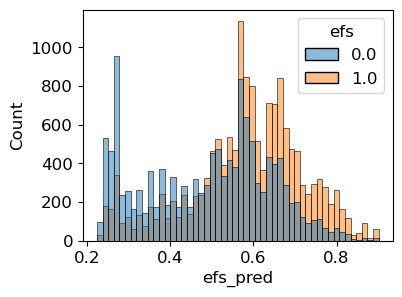

In [172]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

In [ ]:
callback_a = ModelCheckpoint(filepath = '../models/risk_model.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history = model.fit(x=riskx_train, y=risky_train, batch_size=128, epochs=25, validation_data=(riskx_test, risky_test), callbacks=[callback_a, callback_b])

In [173]:
callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
history = model.fit(x=riskx_train, y=risky_train, batch_size=128, epochs=100, validation_data=(riskx_test, risky_test), callbacks=callback)

Epoch 1/100
180/180 [==============================] - 1s 5ms/step - loss: 0.2247 - accuracy: 0.6338 - mse: 0.2247 - mae: 0.4496 - val_loss: 0.2246 - val_accuracy: 0.6361 - val_mse: 0.2246 - val_mae: 0.4481
Epoch 2/100
180/180 [==============================] - 1s 6ms/step - loss: 0.2246 - accuracy: 0.6332 - mse: 0.2246 - mae: 0.4488 - val_loss: 0.2250 - val_accuracy: 0.6339 - val_mse: 0.2250 - val_mae: 0.4493
Epoch 3/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2245 - accuracy: 0.6336 - mse: 0.2245 - mae: 0.4495 - val_loss: 0.2248 - val_accuracy: 0.6345 - val_mse: 0.2248 - val_mae: 0.4487
Epoch 4/100
180/180 [==============================] - 1s 3ms/step - loss: 0.2246 - accuracy: 0.6330 - mse: 0.2246 - mae: 0.4493 - val_loss: 0.2249 - val_accuracy: 0.6352 - val_mse: 0.2249 - val_mae: 0.4486
Epoch 5/100
180/180 [==============================] - 1s 5ms/step - loss: 0.2245 - accuracy: 0.6352 - mse: 0.2245 - mae: 0.4489 - val_loss: 0.2251 - val_accuracy: 0.6300 -

180/180 [==============================] - 1s 3ms/step
AUC:  0.6339012555144533


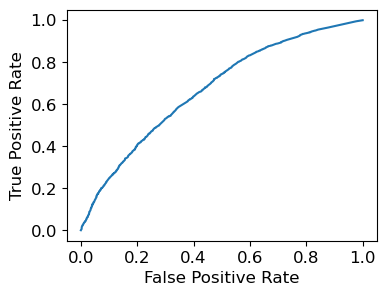

In [174]:
fpr, tpr, thresholds = roc_curve(risky_test, model.predict(riskx_test))

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

In [175]:
x_train_sample = riskx_train.sample(1000).values
risk_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = risk_shap.shap_values(riskx_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=riskx_train.columns.values, data=riskx_test.values, base_values=model.predict(x_train_sample).mean())

C:\Users\kimvo\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


32/32 [==============================] - 0s 3ms/step


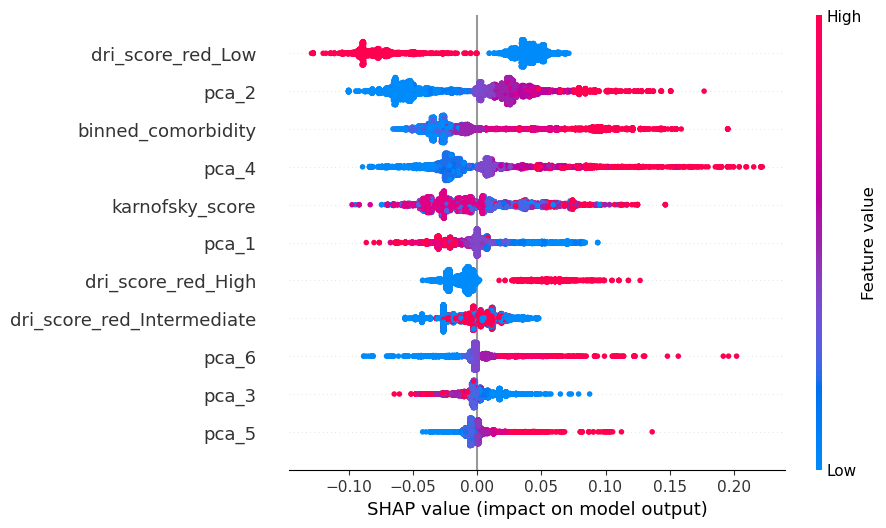

In [176]:
shap.plots.beeswarm(shap_vals, max_display=21)

### Model 7

Refining Model 3

In [10]:
def preprocess_risk(df):
    feature_union = FeatureUnion([
        ('cat_trans', CategoricalTransformer(columns=['dri_score_red', 'cyto_score', 'cyto_score_detail'])),
        ('num_trans', NumericalTransformer(columns=['binned_comorbidity', 'karnofsky_score']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('knn_impute', SimpleImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    transformers = ['cat_trans', 'num_trans']
    cols = []
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    
    return knn_impute_pipe, df_imputed

In [11]:
riskx_train, riskx_test, risky_train, risky_test = train_test_split(df, df['efs'], test_size=0.2)
risk_pipe, riskx_train = preprocess_risk(riskx_train)
riskx_test = pd.DataFrame(risk_pipe.transform(riskx_test), columns=riskx_train.columns)

In [12]:
input_risk = keras.Input(shape=(riskx_train.shape[1],), name='risk_input')
x = layers.Dense(riskx_train.shape[1],activation='relu', name='risk_dense1')(input_risk)
x = layers.BatchNormalization(name='risk_bn1')(x)
x = layers.Dropout(0.1, name='risk_dropout1')(x)
x = layers.Dense(int(riskx_train.shape[1]*2/3), activation='relu', name='risk_dense2')(x)
x = layers.BatchNormalization(name='risk_bn2')(x)
x = layers.Dropout(0.1, name='risk_dropout2')(x)
x = layers.Dense(4,activation='relu', name='risk_dense3')(x)
output_risk = layers.Dense(1, activation='sigmoid', name='risk_out')(x)

model = keras.Model(inputs=input_risk, outputs=output_risk, name='risk_model')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', 'mse', 'mae']
)


Model: "risk_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 risk_input (InputLayer)     [(None, 13)]              0         
                                                                 
 risk_dense1 (Dense)         (None, 13)                182       
                                                                 
 risk_bn1 (BatchNormalizati  (None, 13)                52        
 on)                                                             
                                                                 
 risk_dropout1 (Dropout)     (None, 13)                0         
                                                                 
 risk_dense2 (Dense)         (None, 8)                 112       
                                                                 
 risk_bn2 (BatchNormalizati  (None, 8)                 32        
 on)                                                   

In [13]:
pred, scores = cross_validate(model, preprocess_risk, df, df['efs'], n=5, shuffle=True, random_state=0, save_model=True, name='risk')



Epoch 48: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step


In [14]:
scores

defaultdict(int,
            {'loss': 0.22668013870716094,
             'accuracy': 0.6318142294883728,
             'mse': 0.22668013870716094,
             'mae': 0.4533178627490998,
             'val_loss': 0.22627120316028596,
             'val_accuracy': 0.6335416793823242,
             'val_mse': 0.22627120316028596,
             'val_mae': 0.4530235409736634})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

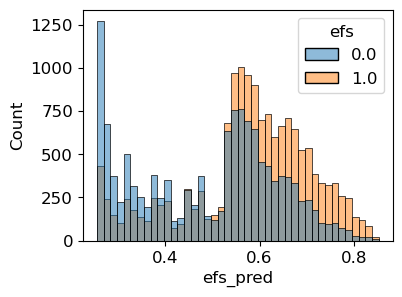

In [15]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

In [30]:
threshold = 0.5
pred_binary = [0 if x < threshold else 1 for x in pred]
cm = confusion_matrix(df['efs'], pred_binary)

In [31]:
cm

array([[ 6034,  7234],
       [ 3378, 12154]], dtype=int64)

In [32]:
cm.diagonal().sum()/cm.sum().sum()

0.6315277777777778

In [254]:
cv_history

defaultdict(int,
            {'loss': 0.22584163844585417,
             'accuracy': 0.6335677027702332,
             'mse': 0.22584163844585417,
             'mae': 0.45170636177062984,
             'val_loss': 0.22603470981121065,
             'val_accuracy': 0.6338194489479065,
             'val_mse': 0.22603470981121065,
             'val_mae': 0.451468700170517})

AUC:  0.6348114285108996


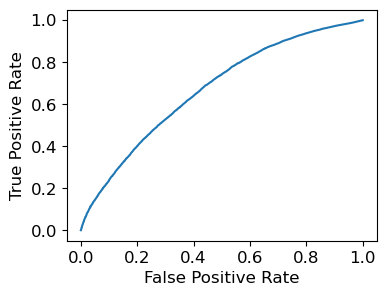

In [68]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

In [69]:
x_train_sample = riskx_train.sample(1000).values
risk_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = risk_shap.shap_values(riskx_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=riskx_train.columns.values, data=riskx_test.values, base_values=model.predict(x_train_sample).mean())

C:\Users\kimvo\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


32/32 [==============================] - 0s 2ms/step


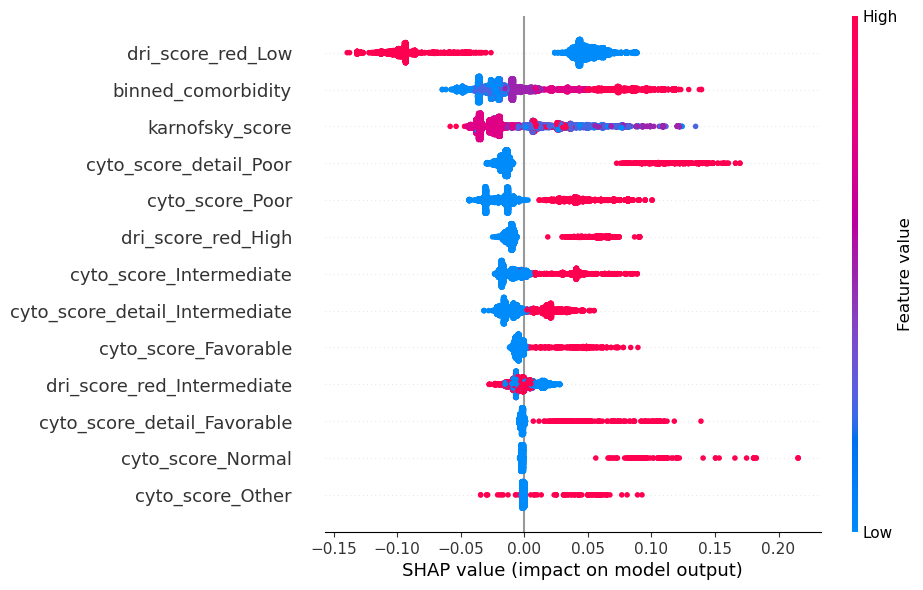

In [70]:
shap.plots.beeswarm(shap_vals, max_display=21)

### Model 8

Trying kaplan meier survival as target

In [71]:
def preprocess_risk(df):
    feature_union = FeatureUnion([
        ('cat_trans', CategoricalTransformer(columns=['dri_score_red', 'cyto_score', 'cyto_score_detail'])),
        ('num_trans', NumericalTransformer(columns=['binned_comorbidity', 'karnofsky_score']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('knn_impute', KNNImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    transformers = ['cat_trans', 'num_trans']
    cols = []
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    
    return knn_impute_pipe, df_imputed

In [72]:
riskx_train, riskx_test, risky_train, risky_test = train_test_split(df, df['y_km'], test_size=0.2)
risk_pipe, riskx_train = preprocess_risk(riskx_train)
riskx_test = pd.DataFrame(risk_pipe.transform(riskx_test), columns=riskx_train.columns)

In [81]:
input_risk = keras.Input(shape=(riskx_train.shape[1],))
x = layers.Dense(riskx_train.shape[1],activation='relu')(input_risk)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(int(riskx_train.shape[1]*2/3),activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(4,activation='relu')(x)
output_risk = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_risk, outputs=output_risk, name='risk_model')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mse', 'mae']
)

Model: "risk_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_37 (Dense)            (None, 13)                182       
                                                                 
 batch_normalization_21 (Ba  (None, 13)                52        
 tchNormalization)                                               
                                                                 
 dropout_21 (Dropout)        (None, 13)                0         
                                                                 
 dense_38 (Dense)            (None, 8)                 112       
                                                                 
 batch_normalization_22 (Ba  (None, 8)                 32        
 tchNormalization)                                      

In [86]:
pred, scores = cross_validate(model, preprocess_risk, df, df['y_km'], n=5, shuffle=True, random_state=0, save_model=False)

Epoch 46: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step


In [87]:
scores

defaultdict(int,
            {'loss': 0.02797650173306465,
             'mse': 0.02797650173306465,
             'mae': 0.14235270023345947,
             'val_loss': 0.027907887101173402,
             'val_mse': 0.027907887101173402,
             'val_mae': 0.1423457056283951})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='y_km_pred', ylabel='Count'>

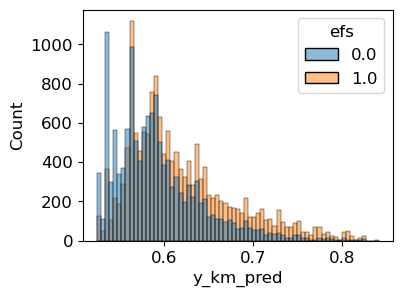

In [88]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='y_km_pred', hue='efs')

AUC:  0.5801602095415849


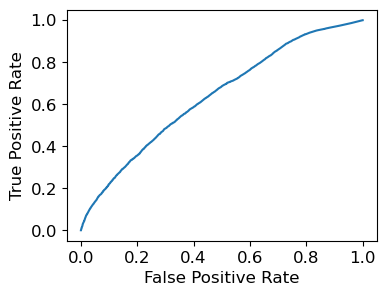

In [89]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

In [ ]:
threshold = 0.5
pred_binary = [0 if x < threshold else 1 for x in pred]
cm = confusion_matrix(df['efs'], pred_binary)

In [ ]:
cm

array([[    0, 13268],
       [    0, 15532]], dtype=int64)

In [ ]:
cm.diagonal().sum()/cm.sum().sum()

0.5393055555555556

In [90]:
x_train_sample = riskx_train.sample(1000).values
risk_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = risk_shap.shap_values(riskx_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=riskx_train.columns.values, data=riskx_test.values, base_values=model.predict(x_train_sample).mean())

C:\Users\kimvo\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


32/32 [==============================] - 0s 3ms/step


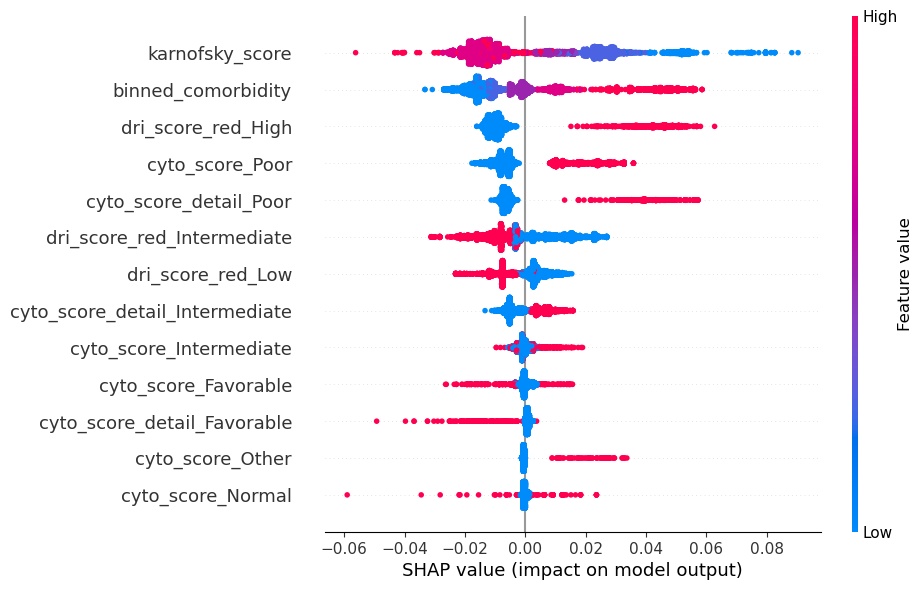

In [91]:
shap.plots.beeswarm(shap_vals, max_display=21)

## Predict EFS Using Only Patient Parameters<a id='predict_efs_using_only_patient_parameters'></a>

### Datatypes and value counts

- **psych_disturb:** psychiatric disturbance
- **diabetes:** diabetes. Known comorbidity, see HCT-CI
- **arrhythmia:** presence of arrhythmia. Known comorbidity, see HCT-CI
- **prim_disease_hct:** Primary disease for HCT
- **rituximab:** Rituximab given in conditioning. Rituximab is a monoclonal antibody that can be used to treat blood cancers including non-Hodgkin lymphoma and forms of leukemia
- **conditioning_intensity:** computed planned conditioning intensity
- **ethnicity:** ethnicity
- **obesity:** obesity. comorbidity
- **in_vivo_tcd:** in-vivo T-cell depletion (ATG/alemtuzumab)
- **hepatic_severe:** hepatic, moderate/severe
- **prior_tumor:** whether patient had prior solid tumor
- **peptic_ulcer:** peptic ulcer. comorbidity
- **rheum_issue:** rheumatologic issue. comorbidity
- **race_group:** race
- **hepatic_mild:** hepatic, mild
- **cardiac:** cardiac. Comorbidity?
- **pulm_moderate:** pulmonary, moderate. comorbidity

In [173]:
patient_cols = ['psych_disturb', 'diabetes', 'arrhythmia', 'prim_disease_hct', 'rituximab', 'conditioning_intensity', 'ethnicity', 'obesity', 'in_vivo_tcd',
                'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'rheum_issue', 'race_group', 'hepatic_mild', 'cardiac', 'pulm_moderate', 'efs']
patient_df = data[patient_cols]

In [174]:
patient_df.dtypes

psych_disturb              object
diabetes                   object
arrhythmia                 object
prim_disease_hct           object
rituximab                  object
conditioning_intensity     object
ethnicity                  object
obesity                    object
in_vivo_tcd                object
hepatic_severe             object
prior_tumor                object
peptic_ulcer               object
rheum_issue                object
race_group                 object
hepatic_mild               object
cardiac                    object
pulm_moderate              object
efs                       float64
dtype: object

In [175]:
patient_df.isna().sum()

psych_disturb             0
diabetes                  0
arrhythmia                0
prim_disease_hct          0
rituximab                 0
conditioning_intensity    0
ethnicity                 0
obesity                   0
in_vivo_tcd               0
hepatic_severe            0
prior_tumor               0
peptic_ulcer              0
rheum_issue               0
race_group                0
hepatic_mild              0
cardiac                   0
pulm_moderate             0
efs                       0
dtype: int64

In [187]:
list(zip(patient_df[patient_cols[0]].value_counts().keys(), patient_df[patient_cols[0]].value_counts().values))

[('No', 23005), ('Yes', 3587), ('NOT TESTED', 2208)]

In [189]:
for col in patient_cols[:-1]:
    print(col, patient_df[col].nunique(), list(zip(patient_df[col].value_counts().keys(), patient_df[col].value_counts().values)))

psych_disturb 3 [('No', 23005), ('Yes', 3587), ('NOT TESTED', 2208)]
diabetes 3 [('No', 22201), ('Yes', 4339), ('NOT TESTED', 2260)]
arrhythmia 3 [('No', 25203), ('NOT TESTED', 2320), ('Yes', 1277)]
prim_disease_hct 18 [('ALL', 8102), ('AML', 7135), ('MDS', 3046), ('IPA', 1719), ('MPN', 1656), ('IEA', 1449), ('NHL', 1319), ('IIS', 1024), ('PCD', 869), ('SAA', 713), ('AI', 449), ('HIS', 445), ('Other leukemia', 366), ('Solid tumor', 207), ('IMD', 144), ('Other acute leukemia', 83), ('HD', 54), ('CML', 20)]
rituximab 3 [('No', 26033), ('NOT TESTED', 2148), ('Yes', 619)]
conditioning_intensity 6 [('MAC', 12288), ('RIC', 7722), ('NOT TESTED', 5162), ('NMA', 3479), ('No drugs reported', 87), ('N/A, F(pre-TED) not submitted', 62)]
ethnicity 4 [('Not Hispanic or Latino', 24482), ('Hispanic or Latino', 3347), ('NOT TESTED', 587), ('Non-resident of the U.S.', 384)]
obesity 3 [('No', 25144), ('NOT TESTED', 1877), ('Yes', 1779)]
in_vivo_tcd 3 [('No', 17591), ('Yes', 10984), ('NOT TESTED', 225)]
h

prim_disease_hct contains 18 unique values that can likely not be reduced

psych_disturb, diabetes, arrhythmia, rituximab, conditioning_intensity, ethnicity, obesity, in_vivo_tcd, hepatic_severe, prior_tumor, peptic_ulcer, rheum_issue, hepatic_mild, cardiac, and pulm_moderate all contain nans

### Model 1

Using full patient feature space

**Result:**

Many of the patient features are comorbidities. If want to reduce the number of dimensions, consider applying dim reduction techniques along with comorbidity score. The patient comorbidity features are psych_distrub, diabetes, arrhythmia, obesity, hepatic_sever, prior_tumor, peptic_ulcer, rheum_issue, hepatic_mild, cardiac, and pulm_moderate

In [16]:
def preprocess_patient(df):
    patient_pipe = Pipeline([
        ('features', FeatureUnion([
            ('patient_cat', CategoricalTransformer(columns=['psych_disturb', 'diabetes', 'arrhythmia', 'prim_disease_hct', 
                                                      'ethnicity', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'rheum_issue',
                                                      'race_group', 'hepatic_mild', 'cardiac', 'pulm_moderate'])),
            ('patient_num', NumericalTransformer(columns=['binned_comorbidity']))
        ]))
    ])

    df_trans = patient_pipe.fit_transform(df)

    cols = []
    transformers = ['patient_cat', 'patient_num']
    for trans in transformers:
        trans_cols = patient_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)
    
    return patient_pipe, pd.DataFrame(df_trans, columns=cols)

In [17]:
patientx_train, patientx_test, patienty_train, patienty_test = train_test_split(df, df['efs'], test_size=0.2)
patient_pipe, patientx_train = preprocess_patient(patientx_train)
patientx_test = pd.DataFrame(patient_pipe.transform(patientx_test), columns=patientx_train.columns)

In [18]:
input_patient = keras.Input(shape=(patientx_train.shape[1],), name='patient_input')
x = layers.Dense(patientx_train.shape[1],activation='relu',name='patient_dense1')(input_patient)
x = layers.BatchNormalization(name='patient_bn1')(x)
x = layers.Dropout(0.1,name='patient_dropout1')(x)
x = layers.Dense(int(patientx_train.shape[1]/2),activation='relu',name='patient_dense2')(x)
x = layers.BatchNormalization(name='patient_bn2')(x)
x = layers.Dropout(0.1,name='patient_dropout2')(x)
x = layers.Dense(4,activation='relu',name='patient_dense3')(x)
output_patient = layers.Dense(1, activation='sigmoid',name='patient_out')(x)

model = keras.Model(inputs=input_patient, outputs=output_patient, name='patient_model')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "patient_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patient_input (InputLayer)  [(None, 32)]              0         
                                                                 
 patient_dense1 (Dense)      (None, 32)                1056      
                                                                 
 patient_bn1 (BatchNormaliz  (None, 32)                128       
 ation)                                                          
                                                                 
 patient_dropout1 (Dropout)  (None, 32)                0         
                                                                 
 patient_dense2 (Dense)      (None, 16)                528       
                                                                 
 patient_bn2 (BatchNormaliz  (None, 16)                64        
 ation)                                              

In [19]:
pred, scores = cross_validate(model, preprocess_patient, df, df['efs'], n=5, shuffle=True, random_state=0, save_model=True, name='patient')

Epoch 31: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step
Epoch 11: early stopping
180/180 [==============================] - 0s 2ms/step


In [20]:
scores

defaultdict(int,
            {'loss': 0.22046900689601898,
             'accuracy': 0.6452083468437195,
             'mse': 0.22046900689601898,
             'mae': 0.44133297801017757,
             'val_loss': 0.22199586033821106,
             'val_accuracy': 0.6412499904632569,
             'val_mse': 0.22199586033821106,
             'val_mae': 0.44246358275413517})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

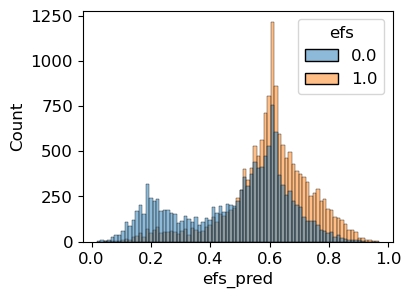

In [73]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

In [ ]:
threshold = 0.5
pred_binary = [0 if x < threshold else 1 for x in pred]
cm = confusion_matrix(df['efs'], pred_binary)

In [ ]:
cm

In [ ]:
cm.diagonal().sum()/cm.sum().sum()

In [ ]:
cv_history

AUC:  0.5850946058051478


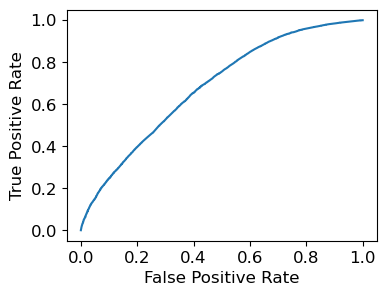

In [74]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

In [66]:
x_train_sample = patientx_train.sample(1000).values
risk_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = risk_shap.shap_values(patientx_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=patientx_train.columns.values, data=patientx_test.values, base_values=model.predict(x_train_sample).mean())

C:\Users\kimvo\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


32/32 [==============================] - 0s 3ms/step


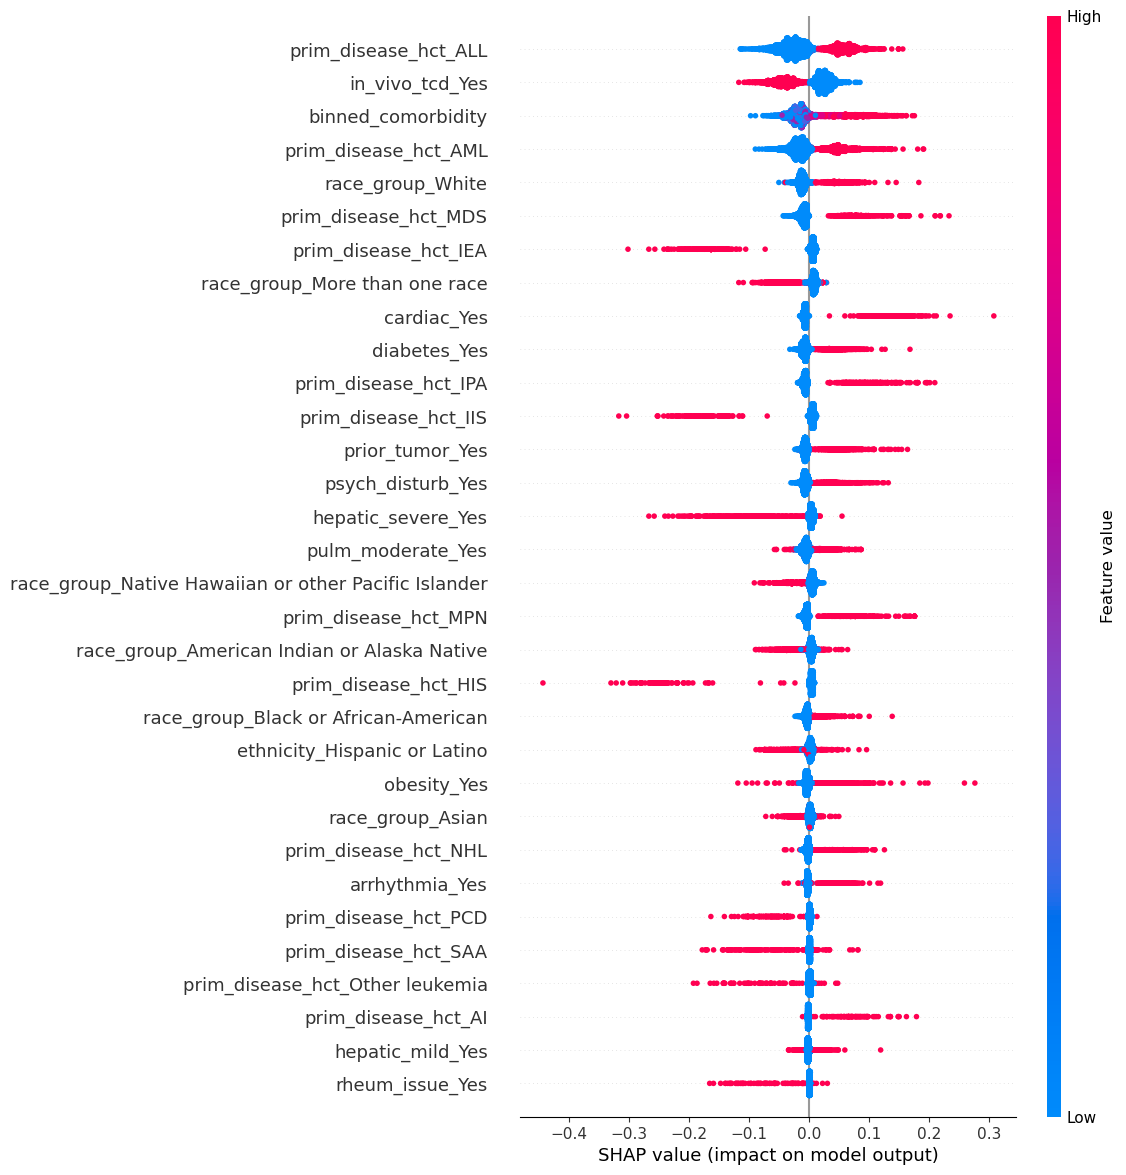

In [67]:
shap.plots.beeswarm(shap_vals, max_display=46)

### Model 2
Applying PCA to comorbidity related features

PCA did not improve accuracy

In [ ]:
cols = ['psych_disturb', 'diabetes', 'arrhythmia', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 
        'prior_tumor', 'peptic_ulcer', 'rheum_issue', 'hepatic_mild', 'cardiac', 'pulm_moderate']
for col in cols:
    print(col, df[col].nunique(), df[col].value_counts())

psych_disturb 3 psych_disturb
No            23005
Yes            3587
NOT TESTED     2208
Name: count, dtype: int64
diabetes 3 diabetes
No            22201
Yes            4339
NOT TESTED     2260
Name: count, dtype: int64
arrhythmia 3 arrhythmia
No            25203
NOT TESTED     2320
Yes            1277
Name: count, dtype: int64
obesity 3 obesity
No            25144
NOT TESTED     1877
Yes            1779
Name: count, dtype: int64
in_vivo_tcd 3 in_vivo_tcd
No            17591
Yes           10984
NOT TESTED      225
Name: count, dtype: int64
hepatic_severe 3 hepatic_severe
No            25238
NOT TESTED     2081
Yes            1481
Name: count, dtype: int64
prior_tumor 3 prior_tumor
No            23828
Yes            3009
NOT TESTED     1963
Name: count, dtype: int64
peptic_ulcer 2 peptic_ulcer
No            25956
NOT TESTED     2844
Name: count, dtype: int64
rheum_issue 3 rheum_issue
No            26015
NOT TESTED     2328
Yes             457
Name: count, dtype: int64
hepatic_mild 3 h

In [195]:
def preprocess_patient(df):
    # place pca after features in pipeline
    patient_pipe = Pipeline([
        ('features', FeatureUnion([
            ('patient_cat', CategoricalTransformer(columns=['psych_disturb', 'diabetes', 'arrhythmia', 'prim_disease_hct', 
                                                      'ethnicity', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'rheum_issue',
                                                      'race_group', 'hepatic_mild', 'cardiac', 'pulm_moderate'])),
            ('patient_num', NumericalTransformer(columns=['binned_comorbidity']))
        ]))
    ])

    df_trans = patient_pipe.fit_transform(df)

    cols = []
    transformers = ['patient_cat', 'patient_num']
    for trans in transformers:
        trans_cols = patient_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)
    
    return patient_pipe, pd.DataFrame(df_trans, columns=cols)

In [196]:
patientx_train, patientx_test, patienty_train, patienty_test = train_test_split(df, df['efs'], test_size=0.2)
patient_pipe, patientx_train = preprocess_patient(patientx_train)
patientx_test = pd.DataFrame(patient_pipe.transform(patientx_test), columns=patientx_train.columns)

drop_cols = patientx_train.columns[patientx_train.columns.str.match('.*No$')]
patientx_train.drop(columns=drop_cols, inplace=True)
patientx_test.drop(columns=drop_cols, inplace=True)

In [197]:
input_patient = keras.Input(shape=(patientx_train.shape[1],))
x = layers.Dense(patientx_train.shape[1],activation='relu')(input_patient)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(int(patientx_train.shape[1]/2),activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(10,activation='relu')(x)
output_patient = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_patient, outputs=output_patient, name='patient_model')
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "patient_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 34)]              0         
                                                                 
 dense_81 (Dense)            (None, 34)                1190      
                                                                 
 batch_normalization_43 (Ba  (None, 34)                136       
 tchNormalization)                                               
                                                                 
 dropout_41 (Dropout)        (None, 34)                0         
                                                                 
 dense_82 (Dense)            (None, 17)                595       
                                                                 
 batch_normalization_44 (Ba  (None, 17)                68        
 tchNormalization)                                   

In [199]:
pred, scores = cross_validate(model, preprocess_patient, df, df['efs'], n=5, shuffle=True, random_state=0, save_model=False)

ValueError: in user code:

    File "C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "patient_model" is incompatible with the layer: expected shape=(None, 34), found shape=(128, 45)


In [200]:
scores

defaultdict(int,
            {'loss': 0.21699653565883636,
             'accuracy': 0.6511892318725585,
             'mse': 0.21699653565883636,
             'mae': 0.4335736036300659,
             'val_loss': 0.2203570395708084,
             'val_accuracy': 0.6438194513320924,
             'val_mse': 0.2203570395708084,
             'val_mae': 0.4371494114398956})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

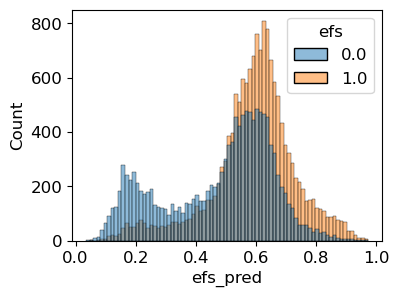

In [164]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

In [ ]:
threshold = 0.5
pred_binary = [0 if x < threshold else 1 for x in pred]
cm = confusion_matrix(df['efs'], pred_binary)

In [ ]:
cm

In [ ]:
cm.diagonal().sum()/cm.sum().sum()

In [ ]:
cv_history

AUC:  0.5526850260572987


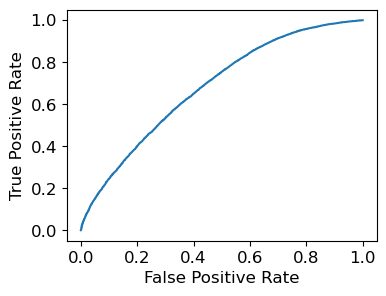

In [165]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

In [166]:
x_train_sample = patientx_train.sample(1000).values
risk_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = risk_shap.shap_values(patientx_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=patientx_train.columns.values, data=patientx_test.values, base_values=model.predict(x_train_sample).mean())

C:\Users\kimvo\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
C:\Users\kimvo\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


32/32 [==============================] - 0s 3ms/step


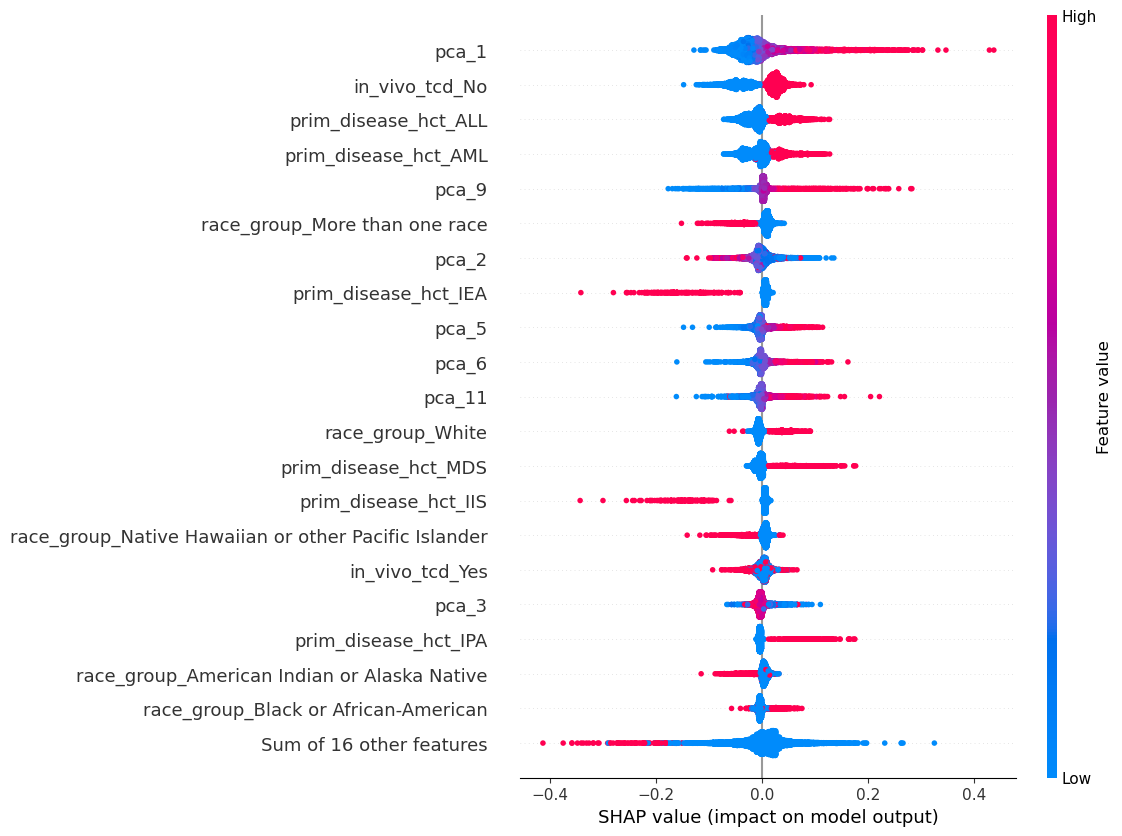

In [167]:
shap.plots.beeswarm(shap_vals, max_display=21)

In [237]:
def preprocess_patient2(df):
    # place pca after features in pipeline
    patient_pipe = Pipeline([
        ('features', CategoricalTransformer(columns=['psych_disturb', 'diabetes', 'arrhythmia', 'prim_disease_hct', 'rituximab', 'conditioning_intensity',
                                                      'ethnicity', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'rheum_issue',
                                                      'race_group', 'hepatic_mild', 'cardiac', 'pulm_moderate'])),
        ('PCA', PCA(n_components=0.95, svd_solver='full'))
    ])

    df_trans = patient_pipe.fit_transform(df)

    cols = ['pca_'+str(i) for i in range(1, df_trans.shape[1]+1)]
    
    df_trans = pd.DataFrame(df_trans, columns=cols)
    
    return patient_pipe, df_trans

In [238]:
patientX, patientY = patient_df.drop(columns=['efs']), patient_df['efs']

patientx_train, patientx_test, patienty_train, patienty_test = train_test_split(patientX, patientY, test_size=0.2)
patient_pipe, patientx_train = preprocess_patient2(patientx_train)
patientx_test = pd.DataFrame(patient_pipe.transform(patientx_test), columns=patientx_train.columns)

In [240]:
patientx_train.shape

(23040, 36)

In [241]:
input_patient = keras.Input(shape=(patientx_train.shape[1],))
x = layers.Dense(patientx_train.shape[1],activation='relu')(input_patient)
x = layers.BatchNormalization()(x)
x = layers.Dense(patientx_train.shape[1],activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(15,activation='relu')(x)
output_patient = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_patient, outputs=output_patient, name='patient_model2')
model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "patient_model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 36)]              0         
                                                                 
 dense_52 (Dense)            (None, 36)                1332      
                                                                 
 batch_normalization_26 (Ba  (None, 36)                144       
 tchNormalization)                                               
                                                                 
 dense_53 (Dense)            (None, 36)                1332      
                                                                 
 batch_normalization_27 (Ba  (None, 36)                144       
 tchNormalization)                                               
                                                                 
 dense_54 (Dense)            (None, 15)             

In [242]:
callback_a = ModelCheckpoint(filepath = '../models/patient_model2.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [243]:
history = model.fit(x=patientx_train.values, y=patienty_train.values, batch_size=128, epochs=100, validation_data=(patientx_test.values, patienty_test.values), callbacks=[callback_a, callback_b])

Epoch 1/100
180/180 [==============================] - 3s 6ms/step - loss: 0.6709 - accuracy: 0.6003 - mse: 0.2381 - mae: 0.4621 - val_loss: 0.6590 - val_accuracy: 0.6130 - val_mse: 0.2333 - val_mae: 0.4766
Epoch 2/100
180/180 [==============================] - 1s 4ms/step - loss: 0.6379 - accuracy: 0.6359 - mse: 0.2235 - mae: 0.4440 - val_loss: 0.6390 - val_accuracy: 0.6375 - val_mse: 0.2241 - val_mae: 0.4517
Epoch 3/100
180/180 [==============================] - 1s 4ms/step - loss: 0.6296 - accuracy: 0.6465 - mse: 0.2197 - mae: 0.4383 - val_loss: 0.6360 - val_accuracy: 0.6311 - val_mse: 0.2227 - val_mae: 0.4440
Epoch 4/100
180/180 [==============================] - 1s 5ms/step - loss: 0.6249 - accuracy: 0.6513 - mse: 0.2177 - mae: 0.4353 - val_loss: 0.6382 - val_accuracy: 0.6306 - val_mse: 0.2236 - val_mae: 0.4445
Epoch 5/100
180/180 [==============================] - 1s 5ms/step - loss: 0.6222 - accuracy: 0.6497 - mse: 0.2165 - mae: 0.4340 - val_loss: 0.6375 - val_accuracy: 0.6330 -

In [244]:
for key in history.history.keys():
    print(key + ': ' + str(history.history[key][-1]))

loss: 0.6056916117668152
accuracy: 0.6656249761581421
mse: 0.20934882760047913
mae: 0.42102208733558655
val_loss: 0.6439417600631714
val_accuracy: 0.6340277791023254
val_mse: 0.22565311193466187
val_mae: 0.4358358681201935


180/180 [==============================] - 0s 2ms/step


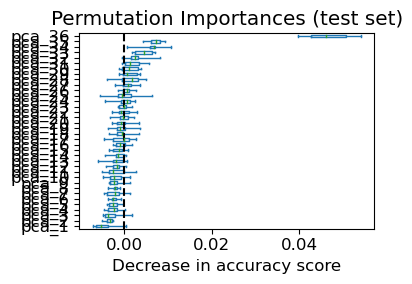

In [246]:
output = layers.Lambda(lambda x: tf.math.round(x))(model.output)
model_importances = keras.Model(model.input, output)
model_importances.load_weights('../models/patient_model2.keras')

result = permutation_importance(model_importances, patientx_test.values, patienty_test.values, n_repeats=10, scoring='accuracy')

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=patientx_test.columns,
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout();

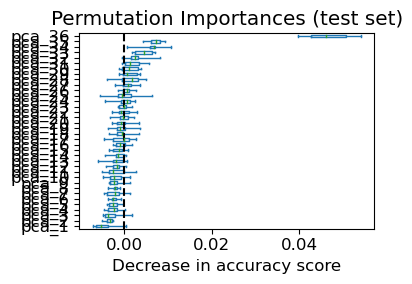

In [247]:
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout();

180/180 [==============================] - 0s 2ms/step
AUC:  0.5434336858313416


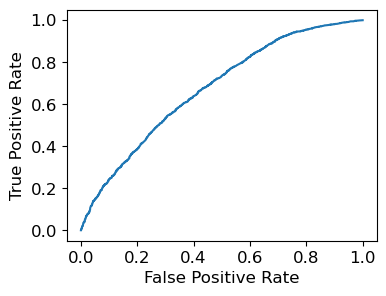

In [248]:
fpr, tpr, thresholds = roc_curve(patienty_test.values, model.predict(patientx_test.values))

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

## Predict EFS With Donor-Recipient Parameters<a id='predict_efs_with_donor-recipient_parameters'></a>

Too many columns for hla matching, attempting to reduce data using dimensionality reduction

### t-SNE of hla features

**Result:**

Clustering unsuccessful but there is some structure

In [137]:
hla_columns = data.columns[data.columns.str.match('hla')]

In [138]:
data[hla_columns]

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,hla_match_a_high,hla_match_b_low,hla_match_a_low,hla_match_b_high,hla_low_res_8,hla_match_drb1_high,hla_low_res_10
0,NaN,NaN,6.0,6.0,NaN,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
1,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
2,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
3,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
4,2.0,8.0,6.0,6.0,10.0,2.0,5.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28795,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
28796,1.0,4.0,5.0,3.0,6.0,2.0,4.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,6.0,1.0,8.0
28797,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,8.0,2.0,10.0
28798,1.0,4.0,3.0,3.0,5.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,5.0


In [139]:
from sklearn.manifold import TSNE

In [146]:
tsne_model = TSNE(perplexity=30, early_exaggeration=4, learning_rate=1000)
xy_tsne = tsne_model.fit_transform(data[hla_columns].dropna())

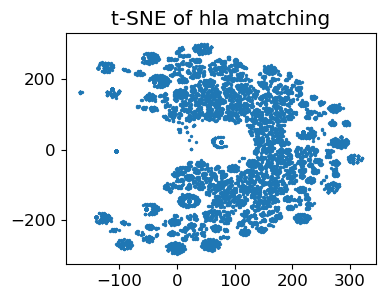

In [148]:
# TSNE(perplexity=30, early_exaggeration=4, learning_rate=1000)
plt.title('t-SNE of hla matching')
plt.scatter(xy_tsne[:,0], xy_tsne[:,1], s=2)

In [151]:
tsne_model.n_iter_

999

899


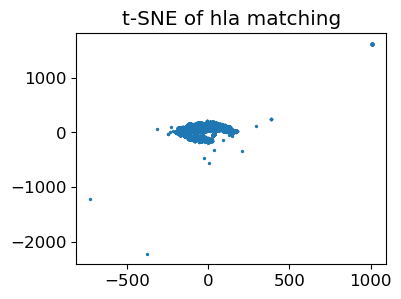

In [ ]:
tsne_model = TSNE(perplexity=50, early_exaggeration=2, learning_rate=5000)
xy_tsne = tsne_model.fit_transform(data[hla_columns].dropna())

plt.title('t-SNE of hla matching')
plt.scatter(xy_tsne[:,0], xy_tsne[:,1], s=2)
print(tsne_model.n_iter_)

(-200.0, 200.0)

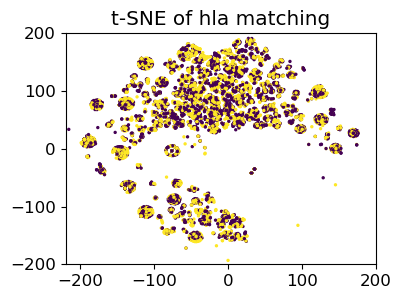

In [245]:
plt.title('t-SNE of hla matching')
plt.scatter(xy_tsne[:,0], xy_tsne[:,1], s=2, c=data[list(hla_columns)+['efs']].dropna()['efs'])
plt.xlim([-220,200])
plt.ylim([-200,200])

999


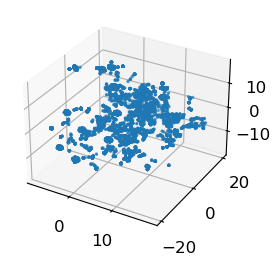

In [167]:
tsne_model = TSNE(n_components=3, perplexity=50, early_exaggeration=1, learning_rate=100)
xy_tsne = tsne_model.fit_transform(data[hla_columns].dropna())
print(tsne_model.n_iter_)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2)
plt.show()

In [170]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:5000,0], xy_tsne[:5000,1], xy_tsne[:5000,2], s=2)
plt.show()

<Axes: xlabel='sum', ylabel='Probability'>

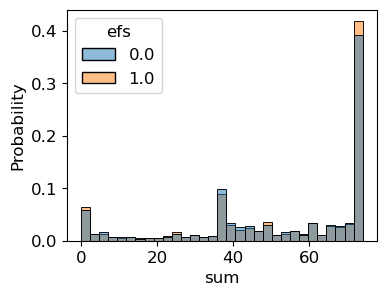

In [241]:
sns.histplot(data=pd.DataFrame({'sum':data[hla_columns].sum(axis=1), 'efs':data['efs']}), x='sum', hue='efs', stat='probability', common_norm=False)

999


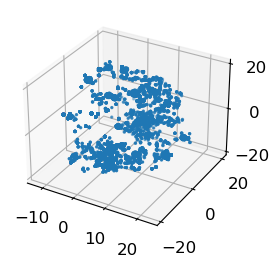

In [183]:
tsne_model = TSNE(n_components=3, perplexity=50, early_exaggeration=1, learning_rate=100)
xy_tsne = tsne_model.fit_transform(((data[hla_columns] - data[hla_columns].mean())/data[hla_columns].std()).dropna())
print(tsne_model.n_iter_)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2)
plt.show()

In [184]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:5000,0], xy_tsne[:5000,1], xy_tsne[:5000,2], s=2)
plt.show()

999


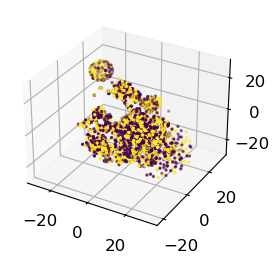

In [207]:
tsne_model = TSNE(n_components=3, perplexity=75, early_exaggeration=1, learning_rate=500, n_iter=5000)
xy_tsne = tsne_model.fit_transform(((data[hla_columns] - data[hla_columns].mean())/data[hla_columns].std()).dropna()[:7250])
c = data[list(hla_columns)+['efs']].dropna()['efs'][:7250]
print(tsne_model.n_iter_)

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()

In [208]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()

899


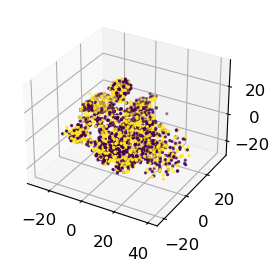

In [209]:
tsne_model = TSNE(n_components=3, perplexity=75, early_exaggeration=1, learning_rate=750, n_iter=5000)
xy_tsne = tsne_model.fit_transform(((data[hla_columns] - data[hla_columns].mean())/data[hla_columns].std()).dropna()[:7250])
c = data[list(hla_columns)+['efs']].dropna()['efs'][:7250]
print(tsne_model.n_iter_)

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()

In [210]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()

4999


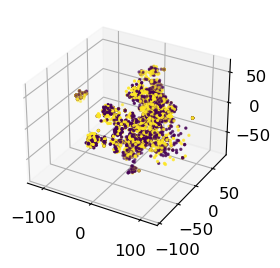

In [226]:
tsne_model = TSNE(n_components=3, perplexity=25, early_exaggeration=1, learning_rate=500, n_iter=5000)
xy_tsne = tsne_model.fit_transform(((data[hla_columns] - data[hla_columns].mean())/data[hla_columns].std()).dropna()[:7250])
c = data[list(hla_columns)+['efs']].dropna()['efs'][:7250]
print(tsne_model.n_iter_)

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()

In [227]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(xy_tsne[:,0], xy_tsne[:,1], xy_tsne[:,2], s=2, c=c)
plt.show()

### Datatypes and value counts

In [378]:
dr_columns = list(data.columns[data.columns.str.match('hla')])
dr_columns.extend(['tce_match', 'tce_div_match', 'tce_imm_match', 'cmv_status', 'sex_match', 'donor_related', 'efs'])

dr_df = data[dr_columns]

In [379]:
dr_df.dtypes

hla_match_c_high       float64
hla_high_res_8         float64
hla_low_res_6          float64
hla_high_res_6         float64
hla_high_res_10        float64
hla_match_dqb1_high    float64
hla_nmdp_6             float64
hla_match_c_low        float64
hla_match_drb1_low     float64
hla_match_dqb1_low     float64
hla_match_a_high       float64
hla_match_b_low        float64
hla_match_a_low        float64
hla_match_b_high       float64
hla_low_res_8          float64
hla_match_drb1_high    float64
hla_low_res_10         float64
tce_match               object
tce_div_match           object
tce_imm_match           object
cmv_status              object
sex_match               object
donor_related           object
efs                    float64
dtype: object

In [380]:
dr_df.isna().sum()

hla_match_c_high       4620
hla_high_res_8         5829
hla_low_res_6          3270
hla_high_res_6         5284
hla_high_res_10        7163
hla_match_dqb1_high    5199
hla_nmdp_6             4197
hla_match_c_low        2800
hla_match_drb1_low     2643
hla_match_dqb1_low     4194
hla_match_a_high       4301
hla_match_b_low        2565
hla_match_a_low        2390
hla_match_b_high       4088
hla_low_res_8          3653
hla_match_drb1_high    3352
hla_low_res_10         5064
tce_match                 0
tce_div_match             0
tce_imm_match             0
cmv_status                0
sex_match                 0
donor_related             0
efs                       0
dtype: int64

In [381]:
for col in ['tce_match', 'tce_div_match', 'tce_imm_match', 'cmv_status', 'sex_match', 'donor_related']:
    print(col, dr_df[col].nunique(), list(zip(dr_df[col].value_counts().keys(), dr_df[col].value_counts().values)))

tce_match 5 [('NOT TESTED', 18996), ('Permissive', 6272), ('GvH non-permissive', 1605), ('Fully matched', 1059), ('HvG non-permissive', 868)]
tce_div_match 5 [('Permissive mismatched', 12936), ('NOT TESTED', 11396), ('GvH non-permissive', 2458), ('HvG non-permissive', 1417), ('Bi-directional non-permissive', 593)]
tce_imm_match 9 [('P/P', 13114), ('NOT TESTED', 11133), ('G/G', 2522), ('H/H', 1084), ('G/B', 544), ('H/B', 229), ('P/H', 83), ('P/B', 66), ('P/G', 25)]
cmv_status 5 [('+/+', 13596), ('-/+', 7081), ('+/-', 4048), ('-/-', 3441), ('NOT TESTED', 634)]
sex_match 5 [('M-M', 7980), ('F-M', 7822), ('M-F', 6715), ('F-F', 6022), ('NOT TESTED', 261)]
donor_related 4 [('Related', 16208), ('Unrelated', 12088), ('Multiple donor (non-UCB)', 346), ('NOT TESTED', 158)]


### Model 1

Full donor-recipient feature space

In [21]:
def preprocess_dr(df):
    # place pca after features in pipeline
    dr_features = FeatureUnion([
        ('dr_cat', CategoricalTransformer(columns=['tce_match', 'tce_div_match', 'tce_imm_match', 'cmv_status', 'sex_match', 'donor_related'])),
        ('dr_num', NumericalTransformer(columns=df.columns[df.columns.str.match('hla')].to_list()))
    ])
    dr_pipe = Pipeline([
        ('features', dr_features),
        ('impute', SimpleImputer())
    ])
    
    df_trans = dr_pipe.fit_transform(df)

    transformers = ['dr_cat', 'dr_num']
    cols = []
    for trans in transformers:
        trans_cols = dr_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_trans = pd.DataFrame(df_trans, columns=cols)

    return dr_pipe, df_trans

In [53]:
def preprocess_dpr(x_train, x_test):
    risk_pipe, riskx_train = preprocess_risk(x_train)
    patient_pipe, patientx_train = preprocess_patient(x_train)
    dr_pipe, drx_train = preprocess_dr(x_train)
    
    riskx_test = pd.DataFrame(risk_pipe.transform(x_test), columns=riskx_train.columns)
    patientx_test = pd.DataFrame(patient_pipe.transform(x_test), columns=patientx_train.columns)
    drx_test = pd.DataFrame(dr_pipe.transform(x_test), columns=drx_train.columns)
    
    return (riskx_train, patientx_train, drx_train), (riskx_test, patientx_test, drx_test)

In [50]:
def gen_dpr_model(drx_train, n_fold):
    dr_shape = drx_train.shape[1]
    risk_model = keras.models.load_model('../models/risk_model_'+str(n_fold)+'fold.keras')
    risk_model.trainable = False
    patient_model = keras.models.load_model('../models/patient_model_'+str(n_fold)+'fold.keras')
    patient_model.trainable = False

    input_dr = keras.Input(shape=(dr_shape,), name='dr_input')
    x_dr = layers.Dense(dr_shape, activation='relu', name='dr_dense1')(input_dr)
    x_dr = layers.BatchNormalization(name='dr_bn1')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout1')(x_dr)
    x_dr = layers.Dense(int(dr_shape/2),activation='relu',name='dr_dense2')(x_dr)
    x_dr = layers.BatchNormalization(name='dr_bn2')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout2')(x_dr)
    x_dr = layers.Dense(int(dr_shape/4),activation='relu',name='dr_dense3')(x_dr)
    x_dr = layers.BatchNormalization(name='dr_bn3')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout3')(x_dr)
    x_dr = layers.Dense(4,activation='relu',name='dr_dense4')(x_dr)

    z = layers.Concatenate(axis=1, name='rpd_concat')([risk_model.layers[-2].output, patient_model.layers[-2].output, x_dr])
    z = layers.BatchNormalization(name='rpd_bn')(z)
    z = layers.Dropout(0.1, name='rpd_dropout')(z)
    z = layers.Dense(4, activation='relu', name='rpd_dense')(z)
    output = layers.Dense(1, activation='sigmoid', name='rpd_out')(z)

    ensemble_model = keras.Model(inputs=[risk_model.inputs, patient_model.inputs, input_dr], outputs=output, 
                                 name='risk_patient_dr_model_'+str(n_fold)+'fold.keras')

    ensemble_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy', 'mse', 'mae']
    )
    return ensemble_model

In [49]:
def cross_validate_dpr(gen_model, preprocessor, X, Y, n=5, shuffle=True, random_state=0, save_model=False, name='dpr'):
    kf = StratifiedKFold(n_splits=n, shuffle=shuffle, random_state=random_state)
    callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    pred = pd.Series(index=Y.index, name=Y.name+'_pred')
    cv_history = defaultdict(int)

    for k, (train_index, test_index) in enumerate(kf.split(X, X['efs'])):
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        
        train_sets, test_sets = preprocessor(x_train, x_test)

        model = gen_model(train_sets[-1], str(k))
        
        if save_model:
            callback_save = ModelCheckpoint(filepath = '../models/'+name+'_model_'+str(k)+'fold.keras', monitor='val_loss', save_best_only=True)
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=[callback_save, callback])
        else:
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=callback)

        pred.loc[test_index] = model.predict(test_sets).reshape(-1)
        for key in history.history.keys():
            cv_history[key] += history.history[key][-1]/n

    return pred, cv_history

In [54]:
pred, scores = cross_validate_dpr(gen_dpr_model, preprocess_dpr, df, df['efs'], n=5, shuffle=True, random_state=0)

Epoch 33: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 28: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 34: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 26: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 25: early stopping
180/180 [==============================] - 1s 3ms/step


In [55]:
scores

defaultdict(int,
            {'loss': 0.2107487380504608,
             'accuracy': 0.6681163311004639,
             'mse': 0.2107487380504608,
             'mae': 0.4214331984519959,
             'val_loss': 0.21215907633304595,
             'val_accuracy': 0.6637847185134889,
             'val_mse': 0.21215907633304595,
             'val_mae': 0.42439947128295896})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

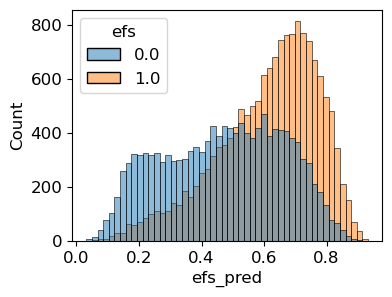

In [57]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.4801206769628817


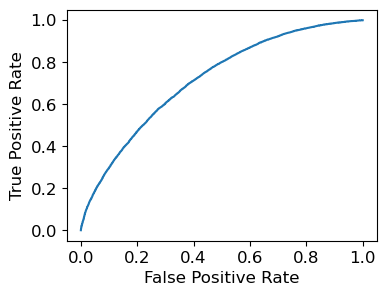

In [58]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

In [ ]:
x_train_sample = drx_train.sample(1000).values
risk_shap = shap.DeepExplainer(model, x_train_sample)
shap_vals = risk_shap.shap_values(drx_test.values)
shap_vals = shap.Explanation(shap_vals[:,:,0], feature_names=drx_train.columns.values, data=drx_test.values, base_values=model.predict(x_train_sample).mean())

In [ ]:
shap.plots.beeswarm(shap_vals, max_display=46)

### Model 2

**Result:** Removing tce_match, tce_div_match, tce_imm_match had minimal impact on accuracy

In [61]:
def preprocess_dr(df):
    # place pca after features in pipeline
    dr_features = FeatureUnion([
        ('dr_cat', CategoricalTransformer(columns=['cmv_status', 'sex_match', 'donor_related'])),
        ('dr_num', NumericalTransformer(columns=df.columns[df.columns.str.match('hla')].to_list()))
    ])
    dr_pipe = Pipeline([
        ('features', dr_features),
        ('impute', SimpleImputer())
    ])
    
    df_trans = dr_pipe.fit_transform(df)

    transformers = ['dr_cat', 'dr_num']
    cols = []
    for trans in transformers:
        trans_cols = dr_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_trans = pd.DataFrame(df_trans, columns=cols)

    return dr_pipe, df_trans

In [63]:
dr_pipe, drx_train = preprocess_dr(df)

In [64]:
drx_train.shape

(28800, 28)

In [53]:
def preprocess_dpr(x_train, x_test):
    risk_pipe, riskx_train = preprocess_risk(x_train)
    patient_pipe, patientx_train = preprocess_patient(x_train)
    dr_pipe, drx_train = preprocess_dr(x_train)
    
    riskx_test = pd.DataFrame(risk_pipe.transform(x_test), columns=riskx_train.columns)
    patientx_test = pd.DataFrame(patient_pipe.transform(x_test), columns=patientx_train.columns)
    drx_test = pd.DataFrame(dr_pipe.transform(x_test), columns=drx_train.columns)
    
    return (riskx_train, patientx_train, drx_train), (riskx_test, patientx_test, drx_test)

In [50]:
def gen_dpr_model(drx_train, n_fold):
    dr_shape = drx_train.shape[1]
    risk_model = keras.models.load_model('../models/risk_model_'+str(n_fold)+'fold.keras')
    risk_model.trainable = False
    patient_model = keras.models.load_model('../models/patient_model_'+str(n_fold)+'fold.keras')
    patient_model.trainable = False

    input_dr = keras.Input(shape=(dr_shape,), name='dr_input')
    x_dr = layers.Dense(dr_shape, activation='relu', name='dr_dense1')(input_dr)
    x_dr = layers.BatchNormalization(name='dr_bn1')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout1')(x_dr)
    x_dr = layers.Dense(int(dr_shape/2),activation='relu',name='dr_dense2')(x_dr)
    x_dr = layers.BatchNormalization(name='dr_bn2')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout2')(x_dr)
    x_dr = layers.Dense(int(dr_shape/4),activation='relu',name='dr_dense3')(x_dr)
    x_dr = layers.BatchNormalization(name='dr_bn3')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout3')(x_dr)
    x_dr = layers.Dense(4,activation='relu',name='dr_dense4')(x_dr)

    z = layers.Concatenate(axis=1, name='rpd_concat')([risk_model.layers[-2].output, patient_model.layers[-2].output, x_dr])
    z = layers.BatchNormalization(name='rpd_bn')(z)
    z = layers.Dropout(0.1, name='rpd_dropout')(z)
    z = layers.Dense(4, activation='relu', name='rpd_dense')(z)
    output = layers.Dense(1, activation='sigmoid', name='rpd_out')(z)

    ensemble_model = keras.Model(inputs=[risk_model.inputs, patient_model.inputs, input_dr], outputs=output, 
                                 name='risk_patient_dr_model_'+str(n_fold)+'fold.keras')

    ensemble_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy', 'mse', 'mae']
    )
    return ensemble_model

In [49]:
def cross_validate_dpr(gen_model, preprocessor, X, Y, n=5, shuffle=True, random_state=0, save_model=False, name='dpr'):
    kf = StratifiedKFold(n_splits=n, shuffle=shuffle, random_state=random_state)
    callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    pred = pd.Series(index=Y.index, name=Y.name+'_pred')
    cv_history = defaultdict(int)

    for k, (train_index, test_index) in enumerate(kf.split(X, X['efs'])):
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        
        train_sets, test_sets = preprocessor(x_train, x_test)

        model = gen_model(train_sets[-1], str(k))
        
        if save_model:
            callback_save = ModelCheckpoint(filepath = '../models/'+name+'_model_'+str(k)+'fold.keras', monitor='val_loss', save_best_only=True)
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=[callback_save, callback])
        else:
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=callback)

        pred.loc[test_index] = model.predict(test_sets).reshape(-1)
        for key in history.history.keys():
            cv_history[key] += history.history[key][-1]/n

    return pred, cv_history

In [65]:
pred, scores = cross_validate_dpr(gen_dpr_model, preprocess_dpr, df, df['efs'], n=5, shuffle=True, random_state=0)

Epoch 33: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 35: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 38: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 52: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 29: early stopping
180/180 [==============================] - 1s 3ms/step


In [66]:
scores

defaultdict(int,
            {'loss': 0.21222061812877654,
             'accuracy': 0.6643402695655822,
             'mse': 0.21222061812877654,
             'mae': 0.4242734372615814,
             'val_loss': 0.21165529787540438,
             'val_accuracy': 0.6651736140251161,
             'val_mse': 0.21165529787540438,
             'val_mae': 0.4250742554664612})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

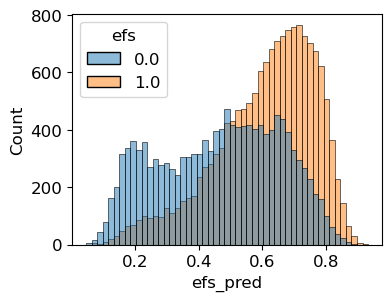

In [67]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.4835284822108071


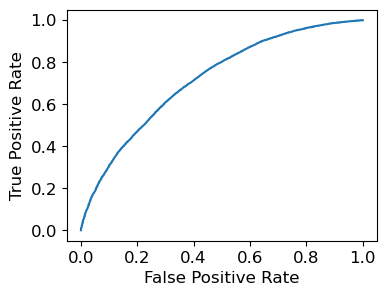

In [68]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

### Model 3

Removing tce_match, tce_div_match and applying PCA to hla features

In [82]:
def preprocess_dr(df):
    # place pca after features in pipeline
    dr_num_pipe = Pipeline([
        ('dr_num', NumericalTransformer(columns=df.columns[df.columns.str.match('hla')].to_list())),
        ('impute_num', SimpleImputer()),
        ('pca_num', PCA(n_components=0.95, svd_solver='full'))
    ])
    dr_features = FeatureUnion([
        ('dr_cat', CategoricalTransformer(columns=['cmv_status', 'sex_match', 'donor_related'])),
        ('dr_num', dr_num_pipe)
    ])
    dr_pipe = Pipeline([
        ('features', dr_features),
        ('impute', SimpleImputer())
    ])
    
    df_trans = dr_pipe.fit_transform(df)

    cols = dr_pipe['features']['dr_cat'].transform(df).columns.to_list()
    cols.extend(['pca_'+str(i) for i in range(1, dr_pipe['features']['dr_num'].transform(df).shape[1]+1)])

    df_trans = pd.DataFrame(df_trans, columns=cols)

    return dr_pipe, df_trans

In [53]:
def preprocess_dpr(x_train, x_test):
    risk_pipe, riskx_train = preprocess_risk(x_train)
    patient_pipe, patientx_train = preprocess_patient(x_train)
    dr_pipe, drx_train = preprocess_dr(x_train)
    
    riskx_test = pd.DataFrame(risk_pipe.transform(x_test), columns=riskx_train.columns)
    patientx_test = pd.DataFrame(patient_pipe.transform(x_test), columns=patientx_train.columns)
    drx_test = pd.DataFrame(dr_pipe.transform(x_test), columns=drx_train.columns)
    
    return (riskx_train, patientx_train, drx_train), (riskx_test, patientx_test, drx_test)

In [50]:
def gen_dpr_model(drx_train, n_fold):
    dr_shape = drx_train.shape[1]
    risk_model = keras.models.load_model('../models/risk_model_'+str(n_fold)+'fold.keras')
    risk_model.trainable = False
    patient_model = keras.models.load_model('../models/patient_model_'+str(n_fold)+'fold.keras')
    patient_model.trainable = False

    input_dr = keras.Input(shape=(dr_shape,), name='dr_input')
    x_dr = layers.Dense(dr_shape, activation='relu', name='dr_dense1')(input_dr)
    x_dr = layers.BatchNormalization(name='dr_bn1')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout1')(x_dr)
    x_dr = layers.Dense(int(dr_shape/2),activation='relu',name='dr_dense2')(x_dr)
    x_dr = layers.BatchNormalization(name='dr_bn2')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout2')(x_dr)
    x_dr = layers.Dense(int(dr_shape/4),activation='relu',name='dr_dense3')(x_dr)
    x_dr = layers.BatchNormalization(name='dr_bn3')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout3')(x_dr)
    x_dr = layers.Dense(4,activation='relu',name='dr_dense4')(x_dr)

    z = layers.Concatenate(axis=1, name='rpd_concat')([risk_model.layers[-2].output, patient_model.layers[-2].output, x_dr])
    z = layers.BatchNormalization(name='rpd_bn')(z)
    z = layers.Dropout(0.1, name='rpd_dropout')(z)
    z = layers.Dense(4, activation='relu', name='rpd_dense')(z)
    output = layers.Dense(1, activation='sigmoid', name='rpd_out')(z)

    ensemble_model = keras.Model(inputs=[risk_model.inputs, patient_model.inputs, input_dr], outputs=output, 
                                 name='risk_patient_dr_model_'+str(n_fold)+'fold.keras')

    ensemble_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy', 'mse', 'mae']
    )
    return ensemble_model

In [49]:
def cross_validate_dpr(gen_model, preprocessor, X, Y, n=5, shuffle=True, random_state=0, save_model=False, name='dpr'):
    kf = StratifiedKFold(n_splits=n, shuffle=shuffle, random_state=random_state)
    callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    pred = pd.Series(index=Y.index, name=Y.name+'_pred')
    cv_history = defaultdict(int)

    for k, (train_index, test_index) in enumerate(kf.split(X, X['efs'])):
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        
        train_sets, test_sets = preprocessor(x_train, x_test)

        model = gen_model(train_sets[-1], str(k))
        
        if save_model:
            callback_save = ModelCheckpoint(filepath = '../models/'+name+'_model_'+str(k)+'fold.keras', monitor='val_loss', save_best_only=True)
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=[callback_save, callback])
        else:
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=callback)

        pred.loc[test_index] = model.predict(test_sets).reshape(-1)
        for key in history.history.keys():
            cv_history[key] += history.history[key][-1]/n

    return pred, cv_history

In [86]:
pred, scores = cross_validate_dpr(gen_dpr_model, preprocess_dpr, df, df['efs'], n=5, shuffle=True, random_state=0)

Epoch 50: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 65: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 75: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 56: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 49: early stopping
180/180 [==============================] - 1s 3ms/step


In [87]:
scores

defaultdict(int,
            {'loss': 0.21252566874027254,
             'accuracy': 0.662439227104187,
             'mse': 0.21252566874027254,
             'mae': 0.42508064508438115,
             'val_loss': 0.21169809699058534,
             'val_accuracy': 0.6644097328186035,
             'val_mse': 0.21169809699058534,
             'val_mae': 0.42547622323036194})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

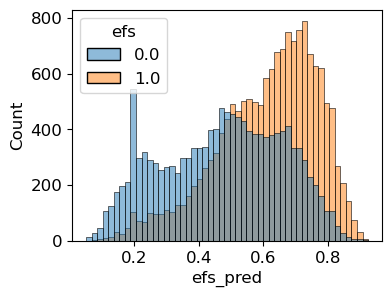

In [88]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.48766857358523097


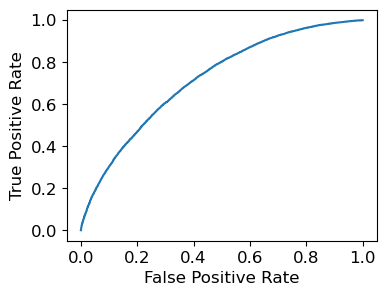

In [89]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

### Model 4

PCA with tce_match, tce_div_match, tce_imm_match

In [118]:
def preprocess_dr(df):
    # place pca after features in pipeline
    dr_num_pipe = Pipeline([
        ('dr_num', NumericalTransformer(columns=df.columns[df.columns.str.match('hla')].to_list())),
        ('impute_num', SimpleImputer()),
        ('pca_num', PCA(n_components=0.95, svd_solver='full'))
    ])
    dr_features = FeatureUnion([
        ('dr_cat', CategoricalTransformer(columns=['tce_match', 'tce_imm_match', 'cmv_status', 'sex_match', 'donor_related'])),
        ('dr_num', dr_num_pipe)
    ])
    dr_pipe = Pipeline([
        ('features', dr_features),
        ('impute', SimpleImputer())
    ])
    
    df_trans = dr_pipe.fit_transform(df)

    cols = dr_pipe['features']['dr_cat'].transform(df).columns.to_list()
    cols.extend(['pca_'+str(i) for i in range(1, dr_pipe['features']['dr_num'].transform(df).shape[1]+1)])

    df_trans = pd.DataFrame(df_trans, columns=cols)

    return dr_pipe, df_trans

In [19]:
def preprocess_rpd(x_train, x_test):
    risk_pipe, riskx_train = preprocess_risk(x_train)
    patient_pipe, patientx_train = preprocess_patient(x_train)
    dr_pipe, drx_train = preprocess_dr(x_train)
    
    riskx_test = pd.DataFrame(risk_pipe.transform(x_test), columns=riskx_train.columns)
    patientx_test = pd.DataFrame(patient_pipe.transform(x_test), columns=patientx_train.columns)
    drx_test = pd.DataFrame(dr_pipe.transform(x_test), columns=drx_train.columns)
    
    return (riskx_train, patientx_train, drx_train), (riskx_test, patientx_test, drx_test)

In [39]:
def gen_rpd_model(drx_train, n_fold):
    dr_shape = drx_train.shape[1]
    risk_model = keras.models.load_model('../models/risk_model_'+str(n_fold)+'fold.keras')
    risk_model.trainable = False
    patient_model = keras.models.load_model('../models/patient_model_'+str(n_fold)+'fold.keras')
    patient_model.trainable = False

    input_dr = keras.Input(shape=(dr_shape,), name='dr_input')
    x_dr = layers.Dense(dr_shape, activation='relu', name='dr_dense1')(input_dr)
    x_dr = layers.BatchNormalization(name='dr_bn1')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout1')(x_dr)
    x_dr = layers.Dense(int(dr_shape/3),activation='relu',name='dr_dense2')(x_dr)
    x_dr = layers.BatchNormalization(name='dr_bn2')(x_dr)
    x_dr = layers.Dropout(0.1,name='dr_dropout2')(x_dr)
    x_dr = layers.Dense(4,activation='relu',name='dr_dense3')(x_dr)

    z = layers.Concatenate(axis=1, name='rpd_concat')([risk_model.layers[-2].output, patient_model.layers[-2].output, x_dr])
    z = layers.BatchNormalization(name='rpd_bn')(z)
    z = layers.Dropout(0.1, name='rpd_dropout')(z)
    z = layers.Dense(4, activation='relu', name='rpd_dense')(z)
    output = layers.Dense(1, activation='sigmoid', name='rpd_out')(z)

    ensemble_model = keras.Model(inputs=[risk_model.inputs, patient_model.inputs, input_dr], outputs=output, 
                                 name='risk_patient_dr_model_'+str(n_fold)+'fold.keras')

    ensemble_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy', 'mse', 'mae']
    )
    return ensemble_model

In [31]:
def cross_validate_rpd(gen_model, preprocessor, X, Y, n=5, shuffle=True, random_state=0, save_model=False, name='rpd'):
    kf = StratifiedKFold(n_splits=n, shuffle=shuffle, random_state=random_state)
    callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    pred = pd.Series(index=Y.index, name=Y.name+'_pred')
    cv_history = defaultdict(int)

    for k, (train_index, test_index) in enumerate(kf.split(X, X['efs'])):
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        
        train_sets, test_sets = preprocessor(x_train, x_test)

        model = gen_model(train_sets[-1], str(k))
        
        if save_model:
            callback_save = ModelCheckpoint(filepath = '../models/'+name+'_model_'+str(k)+'fold.keras', monitor='val_loss', save_best_only=True)
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=[callback_save, callback])
        else:
            history = model.fit(x=train_sets, y=y_train, batch_size=128, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=callback)

        pred.loc[test_index] = model.predict(test_sets).reshape(-1)
        for key in history.history.keys():
            cv_history[key] += history.history[key][-1]/n

    return pred, cv_history

In [22]:
_, drx_train = preprocess_dr(df)
drx_train.shape

(28800, 28)

In [40]:
pred, scores = cross_validate_rpd(gen_rpd_model, preprocess_rpd, df, df['efs'], n=5, shuffle=True, random_state=0, save_model=True, name='rpd')

Epoch 24: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 25: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 35: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 34: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 53: early stopping
180/180 [==============================] - 1s 3ms/step


In [41]:
scores

defaultdict(int,
            {'loss': 0.21160436570644375,
             'accuracy': 0.664817714691162,
             'mse': 0.21160436570644375,
             'mae': 0.4230315685272217,
             'val_loss': 0.21190070509910583,
             'val_accuracy': 0.6619791746139527,
             'val_mse': 0.21190070509910583,
             'val_mae': 0.4245834290981293})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

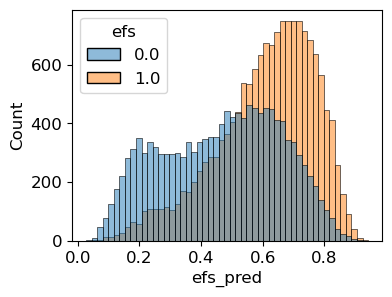

In [42]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.48105049887217133


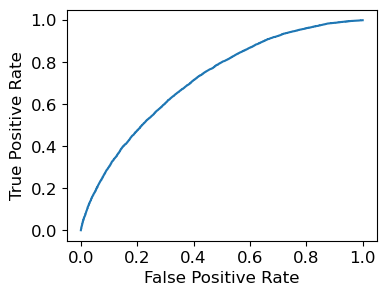

In [43]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

## Predict EFS With HCT Parameters and Donor Age<a id='predict_efs_with_hct_parameters_and_donor_age'></a>

Hoping that there is no time-dependency within data so that I can remove year_hct

#### Yearly trend in EFS

In [361]:
hct_year = data[['year_hct', 'efs']].groupby('year_hct').count().values.reshape(-1)
efs_year = data[['year_hct', 'efs']].groupby('year_hct').sum().values.reshape(-1)

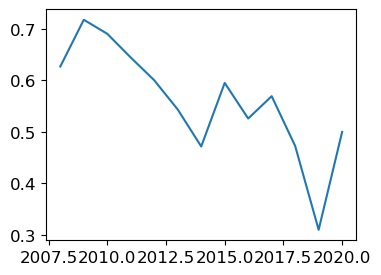

In [362]:
plt.plot(np.arange(2008, 2021, 1), efs_year/hct_year)

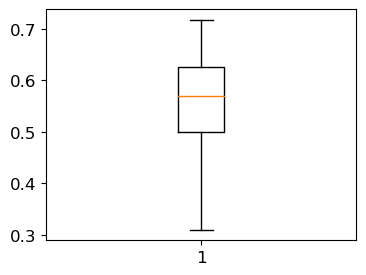

In [365]:
bplot = plt.boxplot(efs_year/hct_year)

### Datatypes and value counts

In [7]:
hct_cols = ['graft_type', 'tbi_status', 'mrd_hct', 'age_at_hct', 'gvhd_proph', 'melphalan_dose', 'donor_age', 'efs']
hct_df = data[hct_cols]

In [8]:
hct_df.dtypes

graft_type         object
tbi_status         object
mrd_hct            object
age_at_hct        float64
gvhd_proph         object
melphalan_dose     object
donor_age         float64
efs               float64
dtype: object

In [9]:
hct_df.isna().sum()

graft_type           0
tbi_status           0
mrd_hct              0
age_at_hct           0
gvhd_proph           0
melphalan_dose       0
donor_age         1808
efs                  0
dtype: int64

In [10]:
for col in ['graft_type', 'tbi_status', 'mrd_hct', 'gvhd_proph', 'melphalan_dose']:
    print(col, hct_df[col].nunique(), list(zip(hct_df[col].value_counts().keys(), hct_df[col].value_counts().values)))

graft_type 2 [('Peripheral blood', 20546), ('Bone marrow', 8254)]
tbi_status 8 [('No TBI', 18861), ('TBI + Cy +- Other', 6104), ('TBI +- Other, <=cGy', 1727), ('TBI +- Other, >cGy', 1700), ('TBI +- Other, -cGy, single', 134), ('TBI +- Other, -cGy, fractionated', 119), ('TBI +- Other, -cGy, unknown dose', 79), ('TBI +- Other, unknown dose', 76)]
mrd_hct 3 [('NOT TESTED', 16597), ('Negative', 8068), ('Positive', 4135)]
gvhd_proph 18 [('FK+ MMF +- others', 10440), ('Cyclophosphamide alone', 5270), ('FK+ MTX +- others(not MMF)', 4262), ('Cyclophosphamide +- others', 2369), ('CSA + MMF +- others(not FK)', 2278), ('FKalone', 1230), ('Other GVHD Prophylaxis', 550), ('TDEPLETION alone', 545), ('TDEPLETION +- other', 539), ('No GvHD Prophylaxis', 262), ('CDselect alone', 251), ('NOT TESTED', 225), ('CSA + MTX +- others(not MMF,FK)', 224), ('CSA alone', 214), ('Parent Q = yes, but no agent', 62), ('CDselect +- other', 55), ('CSA +- others(not FK,MMF,MTX)', 23), ('FK+- others(not MMF,MTX)', 1)]
m

In [11]:
def categorize_age(my_arr):
    age_cat = []
    for x in my_arr:
        if pd.isna(x):
            age_cat.append('NOT TESTED')
        elif x < 1:
            age_cat.append('Infant')
        elif x < 19:
            age_cat.append('Child')
        elif x < 41:
            age_cat.append('Young Adult')
        elif x < 65:
            age_cat.append('Adult')
        else:
            age_cat.append('Senior')
    return age_cat

In [12]:
hct_df['age_at_hct_cat'] = categorize_age(hct_df['age_at_hct'])
hct_df['donor_age_cat'] = categorize_age(hct_df['donor_age'])

C:\Users\kimvo\AppData\Local\Temp\ipykernel_18360\372738402.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hct_df['age_at_hct_cat'] = categorize_age(hct_df['age_at_hct'])
C:\Users\kimvo\AppData\Local\Temp\ipykernel_18360\372738402.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hct_df['donor_age_cat'] = categorize_age(hct_df['donor_age'])


In [54]:
new_gvhd = []
for x in hct_df['gvhd_proph']:
    if x in ['Parent Q = yes, but no agent', 'CDselect +- other', 'CSA +- others(not FK,MMF,MTX)', 'FK+- others(not MMF,MTX)']:
        new_gvhd.append('NOT TESTED')
    else:
        new_gvhd.append(x)
hct_df['gvhd_proph'] = new_gvhd

C:\Users\kimvo\AppData\Local\Temp\ipykernel_18360\3556059898.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hct_df['gvhd_proph'] = new_gvhd


In [58]:
new_tbi = []
for x in hct_df['tbi_status']:
    if x in ['TBI +- Other, -cGy, single', 'TBI +- Other, -cGy, fractionated', 'TBI +- Other, -cGy, unknown dose', 'TBI +- Other, unknown dose']:
        new_tbi.append('NOT TESTED')
    else:
        new_tbi.append(x)
hct_df['tbi_status'] = new_tbi

C:\Users\kimvo\AppData\Local\Temp\ipykernel_18360\3355414558.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hct_df['tbi_status'] = new_tbi


### Model 1

Full hct and donor age feature space

In [8]:
def preprocess_risk(df):
    feature_union = FeatureUnion([
        ('cat_trans', CategoricalTransformer(columns=['dri_score_red', 'cyto_score', 'cyto_score_detail'])),
        ('num_trans', NumericalTransformer(columns=['binned_comorbidity', 'karnofsky_score']))
    ])
    knn_impute_pipe = Pipeline([
        ('features', feature_union),
        ('knn_impute', SimpleImputer())
    ])

    df_imputed = knn_impute_pipe.fit_transform(df)

    transformers = ['cat_trans', 'num_trans']
    cols = []
    for trans in transformers:
        trans_cols = knn_impute_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_imputed = pd.DataFrame(df_imputed, columns=cols)
    
    return knn_impute_pipe, df_imputed

In [9]:
def preprocess_patient(df):
    patient_pipe = Pipeline([
        ('features', FeatureUnion([
            ('patient_cat', CategoricalTransformer(columns=['psych_disturb', 'diabetes', 'arrhythmia', 'prim_disease_hct', 
                                                      'ethnicity', 'obesity', 'in_vivo_tcd', 'hepatic_severe', 'prior_tumor', 'rheum_issue',
                                                      'race_group', 'hepatic_mild', 'cardiac', 'pulm_moderate'])),
            ('patient_num', NumericalTransformer(columns=['binned_comorbidity']))
        ]))
    ])

    df_trans = patient_pipe.fit_transform(df)

    cols = []
    transformers = ['patient_cat', 'patient_num']
    for trans in transformers:
        trans_cols = patient_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)
    
    return patient_pipe, pd.DataFrame(df_trans, columns=cols)

In [10]:
def preprocess_dr(df):
    dr_num_pipe = Pipeline([
        ('dr_num', NumericalTransformer(columns=df.columns[df.columns.str.match('hla')].to_list())),
        ('impute_num', SimpleImputer()),
        ('pca_num', PCA(n_components=0.95, svd_solver='full'))
    ])
    dr_features = FeatureUnion([
        ('dr_cat', CategoricalTransformer(columns=['tce_match', 'tce_imm_match', 'cmv_status', 'sex_match', 'donor_related'])),
        ('dr_num', dr_num_pipe)
    ])
    dr_pipe = Pipeline([
        ('features', dr_features),
        ('impute', SimpleImputer())
    ])
    
    df_trans = dr_pipe.fit_transform(df)

    cols = dr_pipe['features']['dr_cat'].transform(df).columns.to_list()
    cols.extend(['pca_'+str(i) for i in range(1, dr_pipe['features']['dr_num'].transform(df).shape[1]+1)])

    df_trans = pd.DataFrame(df_trans, columns=cols)

    return dr_pipe, df_trans

In [74]:
def preprocess_hct(df):
    hct_pipe = Pipeline([
        ('features', FeatureUnion([
            ('hct_cat', CategoricalTransformer(columns=['graft_type', 'tbi_status', 'mrd_hct', 'melphalan_dose', 'age_at_hct_cat', 'rituximab', 
                                                        'conditioning_intensity', 'gvhd_proph', 'donor_age_cat']))
            # ('hct_num', NumericalTransformer(columns=['donor-pt_age']))
        ]))
    ])

    df_trans = hct_pipe.fit_transform(df)

    transformers = ['hct_cat']
    cols = []
    for trans in transformers:
        trans_cols = hct_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_trans = pd.DataFrame(df_trans, columns=cols)

    return hct_pipe, df_trans

In [18]:
def preprocess_rpdh(x_train, x_test):
    risk_pipe, riskx_train = preprocess_risk(x_train)
    patient_pipe, patientx_train = preprocess_patient(x_train)
    dr_pipe, drx_train = preprocess_dr(x_train)
    hct_pipe, hctx_train = preprocess_hct(x_train)
    
    riskx_test = pd.DataFrame(risk_pipe.transform(x_test), columns=riskx_train.columns)
    patientx_test = pd.DataFrame(patient_pipe.transform(x_test), columns=patientx_train.columns)
    drx_test = pd.DataFrame(dr_pipe.transform(x_test), columns=drx_train.columns)
    hctx_test = pd.DataFrame(hct_pipe.transform(x_test), columns=hctx_train.columns)
    
    return (riskx_train, patientx_train, drx_train, hctx_train), (riskx_test, patientx_test, drx_test, hctx_test)

In [58]:
def gen_rpdh_model(hctx_train, n_fold):    
    hct_shape = hctx_train.shape[1]
    rpd_model = keras.models.load_model('../models/rpd_model_'+str(n_fold)+'fold.keras')
    rpd_model.trainable = False

    input_hct = keras.Input(shape=(hct_shape,), name='hct_input')
    x_hct = layers.Dense(hct_shape, activation='relu', name='hct_dense1')(input_hct)
    x_hct = layers.BatchNormalization(name='hct_bn1')(x_hct)
    x_hct = layers.Dropout(0.1,name='hct_dropout1')(x_hct)
    x_hct = layers.Dense(int(hct_shape/2), activation='relu', name='hct_dense2')(x_hct)
    x_hct = layers.BatchNormalization(name='hct_bn2')(x_hct)
    x_hct = layers.Dropout(0.1,name='hct_dropout2')(x_hct)
    x_hct = layers.Dense(int(hct_shape/2), activation='relu', name='hct_dense3')(x_hct)
    x_hct = layers.BatchNormalization(name='hct_bn3')(x_hct)
    x_hct = layers.Dropout(0.1,name='hct_dropout3')(x_hct)
    x_hct = layers.Dense(4, activation='relu', name='hct_dense4')(x_hct)

    z = layers.Concatenate(axis=1, name='rpdh_concat')([rpd_model.layers[-5].output, x_hct])
    z = layers.BatchNormalization(name='rpdh_bn')(z)
    z = layers.Dropout(0.1, name='rpdh_dropout')(z)
    z = layers.Dense(4, activation='relu', name='rpdh_dense')(z)
    output = layers.Dense(1, activation='sigmoid', name='rpdh_out')(z)

    ensemble_model = keras.Model(inputs=[rpd_model.inputs, input_hct], outputs=output, 
                                 name='rpdh_model_'+str(n_fold)+'fold.keras')

    ensemble_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy', 'mse', 'mae']
    )
    return ensemble_model

In [66]:
def cross_validate_rpdh(gen_model, preprocessor, X, Y, n=5, shuffle=True, random_state=0, save_model=False, name='rpdh'):
    kf = StratifiedKFold(n_splits=n, shuffle=shuffle, random_state=random_state)
    callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    pred = pd.Series(index=Y.index, name=Y.name+'_pred')
    cv_scores = defaultdict(int)

    for k, (train_index, test_index) in enumerate(kf.split(X, X['efs'])):
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        
        train_sets, test_sets = preprocessor(x_train, x_test)

        model = gen_model(train_sets[-1], str(k))
        
        if save_model:
            callback_save = ModelCheckpoint(filepath = '../models/'+name+'_model_'+str(k)+'fold.keras', monitor='val_loss', save_best_only=True)
            history = model.fit(x=train_sets, y=y_train, batch_size=1024, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=[callback_save, callback])
        else:
            history = model.fit(x=train_sets, y=y_train, batch_size=1024, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=callback)

        pred.loc[test_index] = model.predict(test_sets).reshape(-1)
        for key in history.history.keys():
            cv_scores[key] += history.history[key][-1]/n

    return pred, cv_scores

In [75]:
pred, scores = cross_validate_rpdh(gen_rpdh_model, preprocess_rpdh, df, df['efs'], n=5, shuffle=True, random_state=0, save_model=False, name='rpdh')

Epoch 56: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 57: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 71: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 96: early stopping
180/180 [==============================] - 1s 2ms/step
Epoch 78: early stopping
180/180 [==============================] - 1s 2ms/step


In [76]:
scores

defaultdict(int,
            {'loss': 0.2032812923192978,
             'accuracy': 0.686145830154419,
             'mse': 0.2032812923192978,
             'mae': 0.4069336473941803,
             'val_loss': 0.20736672282218932,
             'val_accuracy': 0.6769791603088379,
             'val_mse': 0.20736672282218932,
             'val_mae': 0.41257511377334594})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

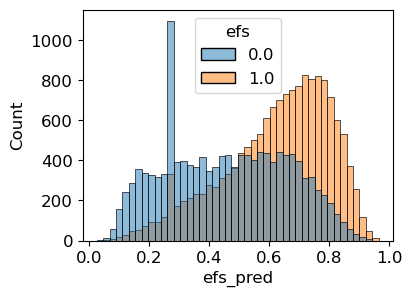

In [77]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.5063725096530536


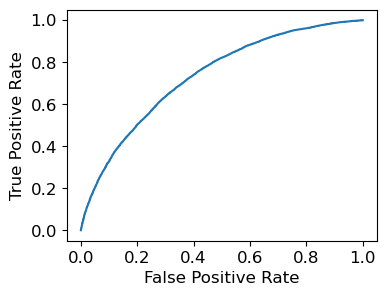

In [78]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

### Model 2

Trying target encoding of gvhd_proph

In [134]:
def preprocess_hct(df):
    hct_pipe = Pipeline([
        ('features', FeatureUnion([
            ('hct_cat', CategoricalTransformer(columns=['graft_type', 'tbi_status', 'mrd_hct', 'melphalan_dose', 'age_at_hct_cat', 'rituximab', 
                                                        'conditioning_intensity', 'donor_age_cat'])),
            ('hct_num', NumericalTransformer(columns=['te_gvhd_proph']))
        ]))
    ])

    df_trans = hct_pipe.fit_transform(df)

    transformers = ['hct_cat', 'hct_num']
    cols = []
    for trans in transformers:
        trans_cols = hct_pipe['features'][trans].transform(df).columns.values
        cols.extend(trans_cols)

    df_trans = pd.DataFrame(df_trans, columns=cols)

    return hct_pipe, df_trans

In [18]:
def preprocess_rpdh(x_train, x_test):
    risk_pipe, riskx_train = preprocess_risk(x_train)
    patient_pipe, patientx_train = preprocess_patient(x_train)
    dr_pipe, drx_train = preprocess_dr(x_train)
    hct_pipe, hctx_train = preprocess_hct(x_train)
    
    riskx_test = pd.DataFrame(risk_pipe.transform(x_test), columns=riskx_train.columns)
    patientx_test = pd.DataFrame(patient_pipe.transform(x_test), columns=patientx_train.columns)
    drx_test = pd.DataFrame(dr_pipe.transform(x_test), columns=drx_train.columns)
    hctx_test = pd.DataFrame(hct_pipe.transform(x_test), columns=hctx_train.columns)
    
    return (riskx_train, patientx_train, drx_train, hctx_train), (riskx_test, patientx_test, drx_test, hctx_test)

In [160]:
def gen_rpdh_model(hctx_train, n_fold):    
    hct_shape = hctx_train.shape[1]
    rpd_model = keras.models.load_model('../models/rpd_model_'+str(n_fold)+'fold.keras')
    rpd_model.trainable = False

    input_hct = keras.Input(shape=(hct_shape,), name='hct_input')
    x_hct = layers.Dense(hct_shape, activation='relu', name='hct_dense1')(input_hct)
    x_hct = layers.BatchNormalization(name='hct_bn1')(x_hct)
    x_hct = layers.Dropout(0.1,name='hct_dropout1')(x_hct)
    x_hct = layers.Dense(int(hct_shape/2), activation='relu', name='hct_dense2')(x_hct)
    x_hct = layers.BatchNormalization(name='hct_bn2')(x_hct)
    x_hct = layers.Dropout(0.1,name='hct_dropout2')(x_hct)
    x_hct = layers.Dense(4, activation='relu', name='hct_dense3')(x_hct)

    z = layers.Concatenate(axis=1, name='rpdh_concat')([rpd_model.layers[-5].output, x_hct])
    z = layers.BatchNormalization(name='rpdh_bn')(z)
    z = layers.Dropout(0.1, name='rpdh_dropout')(z)
    z = layers.Dense(8, activation='relu', name='rpdh_dense1')(z)
    z = layers.BatchNormalization(name='rpdh_bn1')(z)
    z = layers.Dropout(0.1, name='rpdh_dropout1')(z)
    z = layers.Dense(4, activation='relu', name='rpdh_dense2')(z)
    z = layers.BatchNormalization(name='rpdh_bn2')(z)
    z = layers.Dropout(0.1, name='rpdh_dropout2')(z)
    output = layers.Dense(1, activation='sigmoid', name='rpdh_out')(z)

    ensemble_model = keras.Model(inputs=[rpd_model.inputs, input_hct], outputs=output, 
                                 name='rpdh_model_'+str(n_fold)+'fold.keras')

    ensemble_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy', 'mse', 'mae']
    )
    return ensemble_model

In [66]:
def cross_validate_rpdh(gen_model, preprocessor, X, Y, n=5, shuffle=True, random_state=0, save_model=False, name='rpdh'):
    kf = StratifiedKFold(n_splits=n, shuffle=shuffle, random_state=random_state)
    callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    pred = pd.Series(index=Y.index, name=Y.name+'_pred')
    cv_scores = defaultdict(int)

    for k, (train_index, test_index) in enumerate(kf.split(X, X['efs'])):
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        
        train_sets, test_sets = preprocessor(x_train, x_test)

        model = gen_model(train_sets[-1], str(k))
        
        if save_model:
            callback_save = ModelCheckpoint(filepath = '../models/'+name+'_model_'+str(k)+'fold.keras', monitor='val_loss', save_best_only=True)
            history = model.fit(x=train_sets, y=y_train, batch_size=1024, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=[callback_save, callback])
        else:
            history = model.fit(x=train_sets, y=y_train, batch_size=1024, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=callback)

        pred.loc[test_index] = model.predict(test_sets).reshape(-1)
        for key in history.history.keys():
            cv_scores[key] += history.history[key][-1]/n

    return pred, cv_scores

In [165]:
pred, scores = cross_validate_rpdh(gen_rpdh_model, preprocess_rpdh, df, df['efs'], n=5, shuffle=True, random_state=0, save_model=True, name='rpdh')

Epoch 105: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 77: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 77: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 80: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 75: early stopping
180/180 [==============================] - 1s 3ms/step


In [166]:
scores

defaultdict(int,
            {'loss': 0.20634283423423766,
             'accuracy': 0.6817187547683716,
             'mse': 0.20634283423423766,
             'mae': 0.41185708045959474,
             'val_loss': 0.20690488517284394,
             'val_accuracy': 0.6770486235618591,
             'val_mse': 0.20690488517284394,
             'val_mae': 0.4124949455261231})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

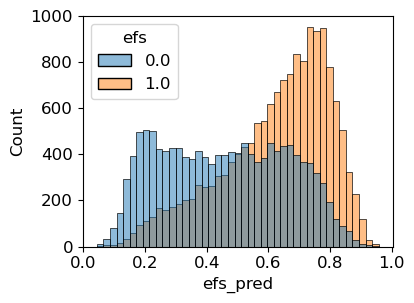

In [167]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.4908085763364359


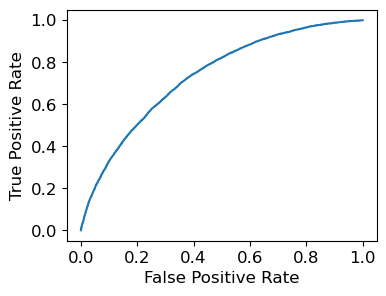

In [168]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

In [126]:
_, hctx_train = preprocess_hct(df.loc[:2500])
my_model = gen_rpdh_model(hctx_train, '0')

In [130]:
my_model.summary()

Model: "rpdh_model_0fold.keras"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 hct_input (InputLayer)      [(None, 24)]                 0         []                            
                                                                                                  
 hct_dense1 (Dense)          (None, 24)                   600       ['hct_input[0][0]']           
                                                                                                  
 risk_input (InputLayer)     [(None, 13)]                 0         []                            
                                                                                                  
 patient_input (InputLayer)  [(None, 32)]                 0         []                            
                                                                             

In [133]:
my_model.get_layer('patient_dense3').trainable = False

### Model 3

Trying PCA. Did not improve accuracy

In [119]:
def preprocess_hct(df):
    hct_pipe = Pipeline([
        ('features', FeatureUnion([
            ('hct_cat', CategoricalTransformer(columns=['graft_type', 'age_at_hct_cat', 'donor_age_cat',
                                                        'tbi_status', 'mrd_hct', 'melphalan_dose', 'rituximab', 'conditioning_intensity'])),
            ('hct_num', NumericalTransformer(columns=['te_gvhd_proph']))
        ])),
        ('pca', PCA(n_components=0.95, svd_solver='full'))
    ])

    df_trans = hct_pipe.fit_transform(df)

    # transformers = ['hct_cat', 'hct_num']
    # cols = []
    # for trans in transformers:
    #     trans_cols = hct_pipe['features'][trans].transform(df).columns.values
    #     cols.extend(trans_cols)
    cols = (['pca_'+str(i) for i in range(1, df_trans.shape[1]+1)])

    df_trans = pd.DataFrame(df_trans, columns=cols)

    return hct_pipe, df_trans

In [18]:
def preprocess_rpdh(x_train, x_test):
    risk_pipe, riskx_train = preprocess_risk(x_train)
    patient_pipe, patientx_train = preprocess_patient(x_train)
    dr_pipe, drx_train = preprocess_dr(x_train)
    hct_pipe, hctx_train = preprocess_hct(x_train)
    
    riskx_test = pd.DataFrame(risk_pipe.transform(x_test), columns=riskx_train.columns)
    patientx_test = pd.DataFrame(patient_pipe.transform(x_test), columns=patientx_train.columns)
    drx_test = pd.DataFrame(dr_pipe.transform(x_test), columns=drx_train.columns)
    hctx_test = pd.DataFrame(hct_pipe.transform(x_test), columns=hctx_train.columns)
    
    return (riskx_train, patientx_train, drx_train, hctx_train), (riskx_test, patientx_test, drx_test, hctx_test)

In [89]:
def gen_rpdh_model(hctx_train, n_fold):    
    hct_shape = hctx_train.shape[1]
    rpd_model = keras.models.load_model('../models/rpd_model_'+str(n_fold)+'fold.keras')
    rpd_model.trainable = False

    input_hct = keras.Input(shape=(hct_shape,), name='hct_input')
    x_hct = layers.Dense(hct_shape, activation='relu', name='hct_dense1')(input_hct)
    x_hct = layers.BatchNormalization(name='hct_bn1')(x_hct)
    x_hct = layers.Dropout(0.1,name='hct_dropout1')(x_hct)
    x_hct = layers.Dense(int(hct_shape/2), activation='relu', name='hct_dense2')(x_hct)
    x_hct = layers.BatchNormalization(name='hct_bn2')(x_hct)
    x_hct = layers.Dropout(0.1,name='hct_dropout2')(x_hct)
    x_hct = layers.Dense(4, activation='relu', name='hct_dense3')(x_hct)

    z = layers.Concatenate(axis=1, name='rpdh_concat')([rpd_model.layers[-5].output, x_hct])
    z = layers.BatchNormalization(name='rpdh_bn')(z)
    z = layers.Dropout(0.1, name='rpdh_dropout')(z)
    z = layers.Dense(4, activation='relu', name='rpdh_dense')(z)
    output = layers.Dense(1, activation='sigmoid', name='rpdh_out')(z)

    ensemble_model = keras.Model(inputs=[rpd_model.inputs, input_hct], outputs=output, 
                                 name='rpdh_model_'+str(n_fold)+'fold.keras')

    ensemble_model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['accuracy', 'mse', 'mae']
    )
    return ensemble_model

In [66]:
def cross_validate_rpdh(gen_model, preprocessor, X, Y, n=5, shuffle=True, random_state=0, save_model=False, name='rpdh'):
    kf = StratifiedKFold(n_splits=n, shuffle=shuffle, random_state=random_state)
    callback = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
    pred = pd.Series(index=Y.index, name=Y.name+'_pred')
    cv_scores = defaultdict(int)

    for k, (train_index, test_index) in enumerate(kf.split(X, X['efs'])):
        x_train, x_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = Y.loc[train_index], Y.loc[test_index]
        
        train_sets, test_sets = preprocessor(x_train, x_test)

        model = gen_model(train_sets[-1], str(k))
        
        if save_model:
            callback_save = ModelCheckpoint(filepath = '../models/'+name+'_model_'+str(k)+'fold.keras', monitor='val_loss', save_best_only=True)
            history = model.fit(x=train_sets, y=y_train, batch_size=1024, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=[callback_save, callback])
        else:
            history = model.fit(x=train_sets, y=y_train, batch_size=1024, epochs=1000, validation_data=(test_sets, y_test), verbose=0, callbacks=callback)

        pred.loc[test_index] = model.predict(test_sets).reshape(-1)
        for key in history.history.keys():
            cv_scores[key] += history.history[key][-1]/n

    return pred, cv_scores

In [115]:
pred, scores = cross_validate_rpdh(gen_rpdh_model, preprocess_rpdh, df, df['efs'], n=5, shuffle=True, random_state=0, save_model=False, name='rpdh')

Epoch 99: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 126: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 145: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 153: early stopping
180/180 [==============================] - 1s 3ms/step
Epoch 88: early stopping
180/180 [==============================] - 1s 3ms/step


In [116]:
scores

defaultdict(int,
            {'loss': 0.20591081380844117,
             'accuracy': 0.6801302075386046,
             'mse': 0.20591081380844117,
             'mae': 0.41261019110679625,
             'val_loss': 0.20733800828456875,
             'val_accuracy': 0.6747222185134888,
             'val_mse': 0.20733800828456875,
             'val_mae': 0.4158725559711457})

C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\kimvo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a len

<Axes: xlabel='efs_pred', ylabel='Count'>

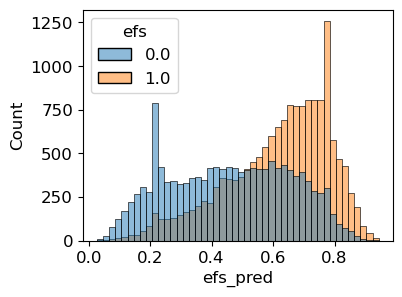

In [117]:
df_pred = pd.concat([df['efs'], pred], axis=1)
sns.histplot(df_pred, x='efs_pred', hue='efs')

AUC:  0.5013755444947963


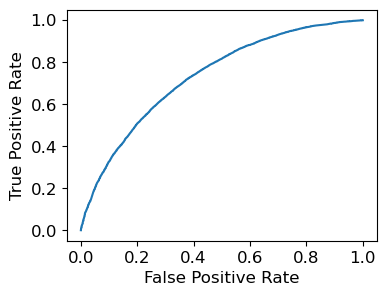

In [118]:
fpr, tpr, thresholds = roc_curve(df['efs'], pred)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

In [84]:
def preprocess_hct2(df):
    # place pca after features in pipeline
    hct_pipe = Pipeline([
        ('cat_trans', CategoricalTransformer(columns=['graft_type', 'tbi_status', 'mrd_hct', 'gvhd_proph',
                                                      'melphalan_dose', 'age_at_hct_cat', 'donor_age_cat'])),
        ('pca', PCA(n_components=0.95, svd_solver='full'))
    ])

    df_trans = hct_pipe.fit_transform(df)

    df_trans = pd.DataFrame(df_trans, columns=['pca_'+str(i) for i in range(1, df_trans.shape[1]+1)])

    return hct_pipe, df_trans

In [85]:
hctX, hctY = hct_df.drop(columns=['efs']), hct_df['efs']

hctx_train, hctx_test, hcty_train, hcty_test = train_test_split(hctX, hctY, test_size=0.2)
hct_pipe, hctx_train = preprocess_hct2(hctx_train)
hctx_test = pd.DataFrame(hct_pipe.transform(hctx_test), columns=hctx_train.columns)

In [63]:
input_hct = keras.Input(shape=(hctx_train.shape[1],))
x = layers.Dense(hctx_train.shape[1],activation='relu')(input_hct)
x = layers.BatchNormalization()(x)
x = layers.Dense(hctx_train.shape[1],activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(10,activation='relu')(x)
output_hct = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=input_hct, outputs=output_hct, name='hct_model2')
model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'mse', 'mae']
)

Model: "hct_model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18)]              0         
                                                                 
 dense_4 (Dense)             (None, 18)                342       
                                                                 
 batch_normalization_2 (Bat  (None, 18)                72        
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 18)                342       
                                                                 
 batch_normalization_3 (Bat  (None, 18)                72        
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 10)                1

In [64]:
callback_a = ModelCheckpoint(filepath = '../models/hct_model2.keras', monitor='val_loss', save_best_only=True)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [65]:
history = model.fit(x=hctx_train.values, y=hcty_train.values, batch_size=128, epochs=100, validation_data=(hctx_test.values, hcty_test.values), callbacks=[callback_a, callback_b]);

Epoch 1/100


180/180 [==============================] - 3s 6ms/step - loss: 0.6831 - accuracy: 0.5853 - mse: 0.2440 - mae: 0.4729 - val_loss: 0.6618 - val_accuracy: 0.6205 - val_mse: 0.2345 - val_mae: 0.4766
Epoch 2/100
180/180 [==============================] - 1s 4ms/step - loss: 0.6564 - accuracy: 0.6223 - mse: 0.2320 - mae: 0.4611 - val_loss: 0.6520 - val_accuracy: 0.6274 - val_mse: 0.2299 - val_mae: 0.4634
Epoch 3/100
180/180 [==============================] - 1s 4ms/step - loss: 0.6516 - accuracy: 0.6246 - mse: 0.2298 - mae: 0.4585 - val_loss: 0.6488 - val_accuracy: 0.6295 - val_mse: 0.2284 - val_mae: 0.4558
Epoch 4/100
180/180 [==============================] - 1s 4ms/step - loss: 0.6487 - accuracy: 0.6296 - mse: 0.2284 - mae: 0.4557 - val_loss: 0.6469 - val_accuracy: 0.6349 - val_mse: 0.2276 - val_mae: 0.4550
Epoch 5/100
180/180 [==============================] - 1s 4ms/step - loss: 0.6469 - accuracy: 0.6330 - mse: 0.2276 - mae: 0.4548 - val_loss: 0.6460 - val_accuracy: 0.6333

In [66]:
for key in history.history.keys():
    print(key + ': ' + str(history.history[key][-1]))

loss: 0.6377268433570862
accuracy: 0.6404947638511658
mse: 0.2234439253807068
mae: 0.4470237195491791
val_loss: 0.644483208656311
val_accuracy: 0.6390625238418579
val_mse: 0.22619041800498962
val_mae: 0.4502825438976288


In [68]:
output = layers.Lambda(lambda x: tf.math.round(x))(model.output)
model_importances = keras.Model(model.input, output)
model_importances.load_weights('../models/hct_model2.keras')

result = permutation_importance(model_importances, hctx_test.values, hcty_test.values, n_repeats=10, scoring='accuracy')

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=hctx_test.columns,
);

180/180 [==============================] - 0s 2ms/step


Text(0.5, 0, 'Decrease in accuracy score')

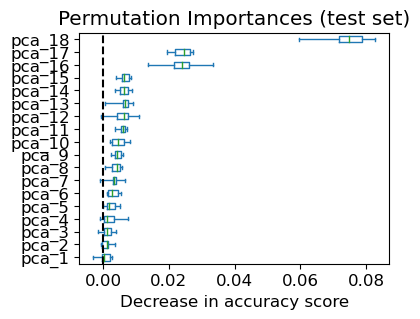

In [69]:
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")

180/180 [==============================] - 0s 2ms/step
AUC:  0.586509190716681


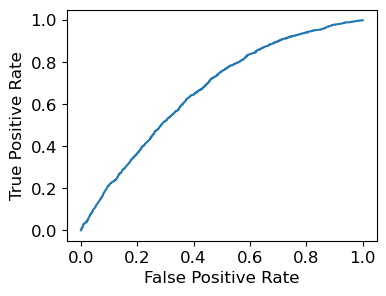

In [70]:
fpr, tpr, thresholds = roc_curve(hcty_test.values, model.predict(hctx_test.values))

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC: ', simpson(tpr, x=fpr))

## Summary

1. Risk, patient, and HCT models result in similar accuracies in the range of 0.62-0.64 while donor-recipient models result in accuracies in the range of 0.56-0.58
2. PCA generally results in increased accuracies especially for reducing the number of dimensions in hla features, hct features, and patient features
3. Dropping features can result in increased accuracy suggesting that there is substantial noise in the dataset
4. Need to go through and drop all feature values that appear less 1% of the time